# Import Libraries

In [134]:
import pymc as pm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Open Data

In [135]:
df = pd.read_csv("data/Spotify_Songs_Cleaned.csv", encoding="latin1")

In [136]:
df.head()

track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts      streams  in_apple_playlists  ...   mode  \
0                147  141381703.0                  43  ...  Major   
1                 48  133716286.0                  48  ...  Major   
2                113  140003974.0                  94  ...  Major   
3                100  800840817.0                 116  ...  Major   
4                 50  303236322.0                  84  ...  Minor   

   danceability_%  valence_%  energy_%  acousticness_% instrumentalness_%  \
0              80         89        83              31                  0   
1              71         61        74               7                  0   
2              51         32        53              17                  0   
3              55         58        72              11                  0   
4              65         23        80              14                 63   

  liveness_%  speechiness_%  day_of_week  Full Key  
0          8              4       Friday   B Major  
1         10              4     Thursday  C# Major  
2         31              6       Friday   F Major  
3         11             15       Friday   A Major  
4         11              6     Thursday   A Minor  

[5 rows x 26 columns]

In [137]:
df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
       'day_of_week', 'Full Key'],
      dtype='object')

In [138]:
df.dtypes

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists     float64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
day_of_week              object
Full Key                 object
dtype: object

# Single Variable Regression

This portion of the analysis asks if any single variable in isolation can predict the number of streams for a song.

In [139]:
x_1var_numeric_reg=df.drop(columns=['track_name','artist(s)_name','key','mode','day_of_week','Full Key','streams'])
y=df['streams']
results_numeric=[]

In [140]:
for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric.append({
        'feature': col,
        'lin_coef': model.coef_[0],
        'lin_intercept': model.intercept_,
        'lin_r2': r2_score(y_test, y_pred),
        'lin_mse': mean_squared_error(y_test,y_pred)
    })

results_df_lin = pd.DataFrame(results_numeric).sort_values(by='lin_r2', ascending=False)
print(results_df_lin)

                 feature      lin_coef  lin_intercept    lin_r2       lin_mse
4   in_spotify_playlists  2.610868e+08   3.615634e+08  0.645982  5.928357e+16
6     in_apple_playlists  2.232191e+08   3.615634e+08  0.562309  7.329527e+16
8    in_deezer_playlists  2.491812e+08   3.615634e+08  0.518198  8.068203e+16
7        in_apple_charts  8.127240e+07   3.615634e+08  0.064151  1.567162e+17
9       in_deezer_charts  9.684745e+07   3.615634e+08  0.063743  1.567847e+17
5      in_spotify_charts  8.998912e+07   3.615634e+08  0.011340  1.655599e+17
18         speechiness_% -2.170131e+07   3.615634e+08  0.009686  1.658369e+17
1          released_year -4.877651e+07   3.615634e+08  0.009196  1.659190e+17
0           artist_count -3.258565e+07   3.615634e+08  0.003364  1.668955e+17
13             valence_% -2.739640e+07   3.615634e+08  0.000849  1.673167e+17
12        danceability_% -3.153226e+07   3.615634e+08 -0.003622  1.680655e+17
10      in_shazam_charts  1.331855e+07   3.615634e+08 -0.004977 

In [141]:
results_numeric_ridge=[]

for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Ridge()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric_ridge.append({
        'feature': col,
        'ridge_coef': model.coef_[0],
        'ridge_intercept': model.intercept_,
        'ridge_r2': r2_score(y_test, y_pred),
        'ridge_mse': mean_squared_error(y_test,y_pred)
    })

results_df_ridge = pd.DataFrame(results_numeric_ridge).sort_values(by='ridge_r2', ascending=False)
print(results_df_ridge)

                 feature    ridge_coef  ridge_intercept  ridge_r2  \
4   in_spotify_playlists  2.606510e+08     3.615634e+08  0.645864   
6     in_apple_playlists  2.228464e+08     3.615634e+08  0.562021   
8    in_deezer_playlists  2.487652e+08     3.615634e+08  0.518420   
7        in_apple_charts  8.113672e+07     3.615634e+08  0.064086   
9       in_deezer_charts  9.668577e+07     3.615634e+08  0.063715   
5      in_spotify_charts  8.983889e+07     3.615634e+08  0.011403   
18         speechiness_% -2.166508e+07     3.615634e+08  0.009665   
1          released_year -4.869508e+07     3.615634e+08  0.009207   
0           artist_count -3.253125e+07     3.615634e+08  0.003356   
13             valence_% -2.735066e+07     3.615634e+08  0.000846   
12        danceability_% -3.147962e+07     3.615634e+08 -0.003615   
10      in_shazam_charts  1.329631e+07     3.615634e+08 -0.004977   
16    instrumentalness_%  1.433633e+06     3.615634e+08 -0.005223   
17            liveness_% -1.536952

In [142]:
results_numeric_lasso=[]

for col in x_1var_numeric_reg.columns:
    x_col=x_1var_numeric_reg[[col]]

    X_train, X_test, y_train, y_test = train_test_split(
    x_col, y, test_size=0.2, random_state=42
    ) 

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso()
    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    
    results_numeric_lasso.append({
        'feature': col,
        'lasso_coef': model.coef_[0],
        'lasso_intercept': model.intercept_,
        'lasso_r2': r2_score(y_test, y_pred),
        'lasso_mse': mean_squared_error(y_test,y_pred)
    })

results_df_lasso = pd.DataFrame(results_numeric_lasso).sort_values(by='lasso_r2', ascending=False)
print(results_df_lasso)

                 feature    lasso_coef  lasso_intercept  lasso_r2  \
4   in_spotify_playlists  2.610868e+08     3.615634e+08  0.645982   
6     in_apple_playlists  2.232191e+08     3.615634e+08  0.562309   
8    in_deezer_playlists  2.491812e+08     3.615634e+08  0.518198   
7        in_apple_charts  8.127240e+07     3.615634e+08  0.064151   
9       in_deezer_charts  9.684745e+07     3.615634e+08  0.063743   
5      in_spotify_charts  8.998912e+07     3.615634e+08  0.011340   
18         speechiness_% -2.170131e+07     3.615634e+08  0.009686   
1          released_year -4.877651e+07     3.615634e+08  0.009196   
0           artist_count -3.258565e+07     3.615634e+08  0.003364   
13             valence_% -2.739639e+07     3.615634e+08  0.000849   
12        danceability_% -3.153226e+07     3.615634e+08 -0.003622   
10      in_shazam_charts  1.331855e+07     3.615634e+08 -0.004977   
16    instrumentalness_%  1.436029e+06     3.615634e+08 -0.005222   
17            liveness_% -1.539522

In [143]:
results_df=pd.merge(results_df_lin,results_df_ridge,on='feature')
results_df=pd.merge(results_df,results_df_lasso,on='feature')
results_df.head(n=20).sort_values(by='lin_r2',ascending=False)

feature      lin_coef  lin_intercept    lin_r2       lin_mse  \
0   in_spotify_playlists  2.610868e+08   3.615634e+08  0.645982  5.928357e+16   
1     in_apple_playlists  2.232191e+08   3.615634e+08  0.562309  7.329527e+16   
2    in_deezer_playlists  2.491812e+08   3.615634e+08  0.518198  8.068203e+16   
3        in_apple_charts  8.127240e+07   3.615634e+08  0.064151  1.567162e+17   
4       in_deezer_charts  9.684745e+07   3.615634e+08  0.063743  1.567847e+17   
5      in_spotify_charts  8.998912e+07   3.615634e+08  0.011340  1.655599e+17   
6          speechiness_% -2.170131e+07   3.615634e+08  0.009686  1.658369e+17   
7          released_year -4.877651e+07   3.615634e+08  0.009196  1.659190e+17   
8           artist_count -3.258565e+07   3.615634e+08  0.003364  1.668955e+17   
9              valence_% -2.739640e+07   3.615634e+08  0.000849  1.673167e+17   
10        danceability_% -3.153226e+07   3.615634e+08 -0.003622  1.680655e+17   
11      in_shazam_charts  1.331855e+07   3.615634e+08 -0.004977  1.682925e+17   
12    instrumentalness_%  1.436030e+06   3.615634e+08 -0.005222  1.683335e+17   
13            liveness_% -1.539522e+07   3.615634e+08 -0.006363  1.685246e+17   
14                   bpm -2.985178e+06   3.615634e+08 -0.007008  1.686325e+17   
15        released_month  2.767881e+07   3.615634e+08 -0.017216  1.703419e+17   
16        acousticness_%  1.885985e+07   3.615634e+08 -0.017934  1.704622e+17   
17          released_day  2.782591e+07   3.615634e+08 -0.025614  1.717482e+17   
18              energy_% -4.058275e+07   3.615634e+08 -0.038134  1.738449e+17   

      ridge_coef  ridge_intercept  ridge_r2     ridge_mse    lasso_coef  \
0   2.606510e+08     3.615634e+08  0.645864  5.930331e+16  2.610868e+08   
1   2.228464e+08     3.615634e+08  0.562021  7.334353e+16  2.232191e+08   
2   2.487652e+08     3.615634e+08  0.518420  8.064488e+16  2.491812e+08   
3   8.113672e+07     3.615634e+08  0.064086  1.567271e+17  8.127240e+07   
4   9.668577e+07     3.615634e+08  0.063715  1.567894e+17  9.684745e+07   
5   8.983889e+07     3.615634e+08  0.011403  1.655494e+17  8.998912e+07   
6  -2.166508e+07     3.615634e+08  0.009665  1.658404e+17 -2.170131e+07   
7  -4.869508e+07     3.615634e+08  0.009207  1.659171e+17 -4.877651e+07   
8  -3.253125e+07     3.615634e+08  0.003356  1.668970e+17 -3.258565e+07   
9  -2.735066e+07     3.615634e+08  0.000846  1.673173e+17 -2.739639e+07   
10 -3.147962e+07     3.615634e+08 -0.003615  1.680643e+17 -3.153226e+07   
11  1.329631e+07     3.615634e+08 -0.004977  1.682923e+17  1.331855e+07   
12  1.433633e+06     3.615634e+08 -0.005223  1.683335e+17  1.436029e+06   
13 -1.536952e+07     3.615634e+08 -0.006359  1.685239e+17 -1.539522e+07   
14 -2.980194e+06     3.615634e+08 -0.007005  1.686320e+17 -2.985177e+06   
15  2.763260e+07     3.615634e+08 -0.017187  1.703371e+17  2.767881e+07   
16  1.882836e+07     3.615634e+08 -0.017909  1.704579e+17  1.885985e+07   
17  2.777946e+07     3.615634e+08 -0.025572  1.717412e+17  2.782591e+07   
18 -4.051499e+07     3.615634e+08 -0.038061  1.738325e+17 -4.058274e+07   

    lasso_intercept  lasso_r2     lasso_mse  
0      3.615634e+08  0.645982  5.928357e+16  
1      3.615634e+08  0.562309  7.329527e+16  
2      3.615634e+08  0.518198  8.068203e+16  
3      3.615634e+08  0.064151  1.567162e+17  
4      3.615634e+08  0.063743  1.567847e+17  
5      3.615634e+08  0.011340  1.655599e+17  
6      3.615634e+08  0.009686  1.658369e+17  
7      3.615634e+08  0.009196  1.659190e+17  
8      3.615634e+08  0.003364  1.668955e+17  
9      3.615634e+08  0.000849  1.673167e+17  
10     3.615634e+08 -0.003622  1.680655e+17  
11     3.615634e+08 -0.004977  1.682925e+17  
12     3.615634e+08 -0.005222  1.683335e+17  
13     3.615634e+08 -0.006363  1.685246e+17  
14     3.615634e+08 -0.007008  1.686325e+17  
15     3.615634e+08 -0.017216  1.703419e+17  
16     3.615634e+08 -0.017934  1.704622e+17  
17     3.615634e+08 -0.025614  1.717482e+17  
18     3.615634e+08 -

In [144]:
categorical_features = ['day_of_week', 'key','mode','Full Key']
results_cat = []

for cat in categorical_features:
    X_cat = pd.get_dummies(df[cat], drop_first=True)  #one-hot encoding, need to drop_first for linear regression

    X_train, X_test, y_train, y_test = train_test_split(
        X_cat, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    for i, dummy_col in enumerate(X_cat.columns):
        results_cat.append({
            'feature': f"{cat}_{dummy_col}",
            'lin_coef': model.coef_[i],
            'lin_intercept': model.intercept_,
            'lin_r2': r2_score(y_test, y_pred),
            'lin_mse': mean_squared_error(y_test,y_pred)
        })

results_cat_df = pd.DataFrame(results_cat).sort_values(by='lin_r2', ascending=True)
print(results_cat_df)


                  feature      lin_coef  lin_intercept    lin_r2       lin_mse
24       Full Key_D Major  2.027913e+07   3.615634e+08 -0.043664  1.747708e+17
31       Full Key_F Minor -2.602059e+06   3.615634e+08 -0.043664  1.747708e+17
29       Full Key_E Minor -8.838241e+06   3.615634e+08 -0.043664  1.747708e+17
30       Full Key_F Major  1.912185e+07   3.615634e+08 -0.043664  1.747708e+17
27      Full Key_D# Minor -1.238430e+07   3.615634e+08 -0.043664  1.747708e+17
26      Full Key_D# Major -3.786377e+06   3.615634e+08 -0.043664  1.747708e+17
25       Full Key_D Minor -6.747889e+06   3.615634e+08 -0.043664  1.747708e+17
28       Full Key_E Major  1.734807e+07   3.615634e+08 -0.043664  1.747708e+17
20       Full Key_B Major -1.603414e+07   3.615634e+08 -0.043664  1.747708e+17
23      Full Key_C# Minor  2.087353e+07   3.615634e+08 -0.043664  1.747708e+17
21       Full Key_B Minor  2.399021e+07   3.615634e+08 -0.043664  1.747708e+17
22      Full Key_C# Major  1.030531e+07   3.615634e+

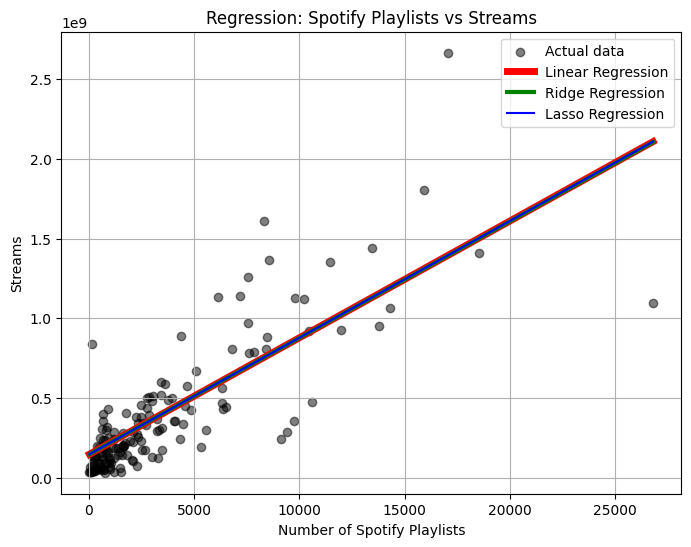

In [145]:
X = df[['in_spotify_playlists']]
y = df['streams']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_lin = model.predict(X_test_scaled)

model= Ridge()
model.fit(X_train_scaled, y_train)
y_pred_ridge = model.predict(X_test_scaled)

model= Lasso()
model.fit(X_train_scaled, y_train)
y_pred_lasso = model.predict(X_test_scaled)

#sorted for clean line plotting
sorted_idx = np.argsort(X_test.values.flatten())
X_test_sorted = X_test.values.flatten()[sorted_idx]
y_pred_lin_sorted = y_pred_lin[sorted_idx]
y_pred_ridge_sorted = y_pred_ridge[sorted_idx]
y_pred_lasso_sorted = y_pred_lasso[sorted_idx]

#plotting code
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual data',color='black')
plt.plot(X_test_sorted, y_pred_lin_sorted, color='red', label='Linear Regression',lw=5)
plt.plot(X_test_sorted, y_pred_ridge_sorted, color='green', label='Ridge Regression',lw=3)
plt.plot(X_test_sorted, y_pred_lasso_sorted, color='blue', label='Lasso Regression')

plt.xlabel('Number of Spotify Playlists')
plt.ylabel('Streams')
plt.title('Regression: Spotify Playlists vs Streams')
plt.legend()
plt.grid(True)
plt.show()


For single variable regression, each variable was compared independently with Linear, Ridge, and Lasso Regression. As shown by the results_df table, all of the values across each single feature were nearly identical. This makes sense because with only one predictor each model becomes nearly identical and the regularization components of Ridge and Lasso Regression don't come into effect. Bayesian regression wasn't included in this analysis because with only one predictor, the Bayesian posterior mean with Gaussian priors would match the frequentist values in the other regression models. 

Through this single-variable analysis, it was determined that the feature that had the highest r2 score (approximately .646) and smallest MSE was Spotify playlists. This makes sense because the streams are collected on the Spotify platform. The graph above also shows an interesting feature of our data that it is highly concentrated for spotify playlists under 15,000. This means with only a few outlier points of the hundreds of data points in our set, they don't have much of an influence on slope of the regression line.

Interestingly, when analyzed independently the one-hot encoded categorical variables for the day_of_the_week, released_month, and full_key (includes key and mode) all had negative R2 scores when linear regression was applied to the data. The negative R2 scores indicate that predicting with these features alone performs worse than just predicting the mean value of streams. These negative scores could be a result of them being features that we engineered or also because there are some innate dependencies that are unable to be captured with single-variable analysis.

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in a reduced dataset of size 100 (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [183]:
# Multivariate numeric features (no categorical, no target)
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

df_reduced=df[0:100]

X_multi = df_reduced[musical_features]
y = df_reduced['streams']


In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [185]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_df_lin['lin_intercept'] = lin_model.intercept_
results_df_lin['lin_r2'] = r2_score(y_test, y_pred_lin)
results_df_lin['lin_mse'] = mean_squared_error(y_test, y_pred_lin)

print(results_df_lin)


              feature      lin_coef  lin_intercept    lin_r2       lin_mse
0                 bpm -1.015544e+08   4.613622e+08 -0.186284  1.909460e+17
1      danceability_% -7.807171e+07   4.613622e+08 -0.186284  1.909460e+17
2            energy_% -1.071739e+08   4.613622e+08 -0.186284  1.909460e+17
3           valence_%  6.091595e+07   4.613622e+08 -0.186284  1.909460e+17
4      acousticness_% -6.500290e+07   4.613622e+08 -0.186284  1.909460e+17
5  instrumentalness_% -2.148499e+07   4.613622e+08 -0.186284  1.909460e+17
6          liveness_% -1.184878e+08   4.613622e+08 -0.186284  1.909460e+17
7       speechiness_%  9.278710e+07   4.613622e+08 -0.186284  1.909460e+17


In [186]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_df_ridge['ridge_intercept'] = ridge_model.intercept_
results_df_ridge['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_df_ridge['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)

print(results_df_ridge)


              feature    ridge_coef  ridge_intercept  ridge_r2     ridge_mse
0                 bpm -9.859588e+07     4.613622e+08 -0.174786  1.890953e+17
1      danceability_% -7.446793e+07     4.613622e+08 -0.174786  1.890953e+17
2            energy_% -1.050562e+08     4.613622e+08 -0.174786  1.890953e+17
3           valence_%  5.753639e+07     4.613622e+08 -0.174786  1.890953e+17
4      acousticness_% -6.220264e+07     4.613622e+08 -0.174786  1.890953e+17
5  instrumentalness_% -2.105174e+07     4.613622e+08 -0.174786  1.890953e+17
6          liveness_% -1.162780e+08     4.613622e+08 -0.174786  1.890953e+17
7       speechiness_%  9.101254e+07     4.613622e+08 -0.174786  1.890953e+17


In [187]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_df_lasso['lasso_intercept'] = lasso_model.intercept_
results_df_lasso['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_df_lasso['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)

print(results_df_lasso)


              feature    lasso_coef  lasso_intercept  lasso_r2     lasso_mse
0                 bpm -1.015544e+08     4.613622e+08 -0.186284  1.909460e+17
1      danceability_% -7.807171e+07     4.613622e+08 -0.186284  1.909460e+17
2            energy_% -1.071739e+08     4.613622e+08 -0.186284  1.909460e+17
3           valence_%  6.091595e+07     4.613622e+08 -0.186284  1.909460e+17
4      acousticness_% -6.500290e+07     4.613622e+08 -0.186284  1.909460e+17
5  instrumentalness_% -2.148499e+07     4.613622e+08 -0.186284  1.909460e+17
6          liveness_% -1.184878e+08     4.613622e+08 -0.186284  1.909460e+17
7       speechiness_%  9.278710e+07     4.613622e+08 -0.186284  1.909460e+17


In [188]:
results_musical = results_df_lin.merge(results_df_ridge, on='feature')
results_musical = results_musical.merge(results_df_lasso, on='feature')

results_musical


feature      lin_coef  lin_intercept    lin_r2       lin_mse  \
0                 bpm -1.015544e+08   4.613622e+08 -0.186284  1.909460e+17   
1      danceability_% -7.807171e+07   4.613622e+08 -0.186284  1.909460e+17   
2            energy_% -1.071739e+08   4.613622e+08 -0.186284  1.909460e+17   
3           valence_%  6.091595e+07   4.613622e+08 -0.186284  1.909460e+17   
4      acousticness_% -6.500290e+07   4.613622e+08 -0.186284  1.909460e+17   
5  instrumentalness_% -2.148499e+07   4.613622e+08 -0.186284  1.909460e+17   
6          liveness_% -1.184878e+08   4.613622e+08 -0.186284  1.909460e+17   
7       speechiness_%  9.278710e+07   4.613622e+08 -0.186284  1.909460e+17   

     ridge_coef  ridge_intercept  ridge_r2     ridge_mse    lasso_coef  \
0 -9.859588e+07     4.613622e+08 -0.174786  1.890953e+17 -1.015544e+08   
1 -7.446793e+07     4.613622e+08 -0.174786  1.890953e+17 -7.807171e+07   
2 -1.050562e+08     4.613622e+08 -0.174786  1.890953e+17 -1.071739e+08   
3  5.753639e+07     4.613622e+08 -0.174786  1.890953e+17  6.091595e+07   
4 -6.220264e+07     4.613622e+08 -0.174786  1.890953e+17 -6.500290e+07   
5 -2.105174e+07     4.613622e+08 -0.174786  1.890953e+17 -2.148499e+07   
6 -1.162780e+08     4.613622e+08 -0.174786  1.890953e+17 -1.184878e+08   
7  9.101254e+07     4.613622e+08 -0.174786  1.890953e+17  9.278710e+07   

   lasso_intercept  lasso_r2     lasso_mse  
0     4.613622e+08 -0.186284  1.909460e+17  
1     4.613622e+08 -0.186284  1.909460e+17  
2     4.613622e+08 -0.186284  1.909460e+17  
3     4.613622e+08 -0.186284  1.909460e+17  
4     4.613622e+08 -0.186284  1.909460e+17  
5     4.613622e+08 -0.186284  1.909460e+17  
6     4.613622e+08 -0.186284  1.909460e+17  
7     4.613622e+08 -0.186284  1.909460e+17

In [189]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()

Weak Prior 

In [190]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_musical_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=1e6)
    slope = pm.Normal("slope", mu=0, sigma=5e5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=1e6)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    weak_sample = pm.sample(draws=500, tune=500, chains=2, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 54 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [191]:
az.summary(weak_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.002  0.098  -0.196    0.178      0.002    0.003   
slope[bpm]                -0.187  0.115  -0.416    0.014      0.003    0.003   
slope[danceability_%]     -0.118  0.131  -0.341    0.152      0.004    0.004   
slope[energy_%]           -0.172  0.127  -0.402    0.060      0.004    0.003   
slope[valence_%]           0.080  0.119  -0.156    0.284      0.004    0.003   
slope[acousticness_%]     -0.085  0.113  -0.309    0.121      0.003    0.003   
slope[instrumentalness_%] -0.004  0.103  -0.189    0.186      0.002    0.003   
slope[liveness_%]         -0.234  0.105  -0.436   -0.047      0.003    0.004   
slope[speechiness_%]       0.104  0.121  -0.127    0.323      0.003    0.004   
sigma                      0.997  0.073   0.871    1.132      0.002    0.003   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1654.0     737.0   1.01  
slope[bpm]                   1312.0     757.0   1.00  
slope[danceability_%]        1135.0     910.0   1.00  
slope[energy_%]              1113.0     854.0   1.00  
slope[valence_%]             1139.0     876.0   1.00  
slope[acousticness_%]        1289.0     876.0   1.00  
slope[instrumentalness_%]    1800.0     734.0   1.00  
slope[liveness_%]            1420.0     835.0   1.00  
slope[speechiness_%]         1282.0     745.0   1.00  
sigma                        1527.0     774.0   1.00

Strong Prior 

In [192]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_strong_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_scaled.values, slope)

    likelihood = pm.Normal(
        "streams",
        mu=mu,
        sigma=sigma,
        observed=y_scaled
    )

    strong_sample = pm.sample(
        draws=500, tune=500, chains=2, random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 52 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [193]:
az.summary(strong_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.000  0.105  -0.185    0.195      0.002    0.004   
slope[bpm]                -0.187  0.112  -0.421    0.002      0.003    0.004   
slope[danceability_%]     -0.120  0.137  -0.376    0.138      0.004    0.004   
slope[energy_%]           -0.169  0.122  -0.414    0.042      0.004    0.003   
slope[valence_%]           0.077  0.123  -0.157    0.302      0.004    0.003   
slope[acousticness_%]     -0.082  0.114  -0.270    0.155      0.003    0.003   
slope[instrumentalness_%] -0.006  0.097  -0.192    0.171      0.003    0.003   
slope[liveness_%]         -0.232  0.107  -0.428   -0.032      0.003    0.003   
slope[speechiness_%]       0.097  0.121  -0.124    0.305      0.004    0.004   
sigma                      0.999  0.073   0.857    1.124      0.002    0.002   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1910.0     770.0    1.0  
slope[bpm]                   1289.0     850.0    1.0  
slope[danceability_%]        1278.0     851.0    1.0  
slope[energy_%]               933.0     947.0    1.0  
slope[valence_%]             1148.0     876.0    1.0  
slope[acousticness_%]        1193.0     845.0    1.0  
slope[instrumentalness_%]    1345.0     689.0    1.0  
slope[liveness_%]            1437.0     823.0    1.0  
slope[speechiness_%]         1137.0     803.0    1.0  
sigma                        1196.0     855.0    1.0

Forest Plot

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

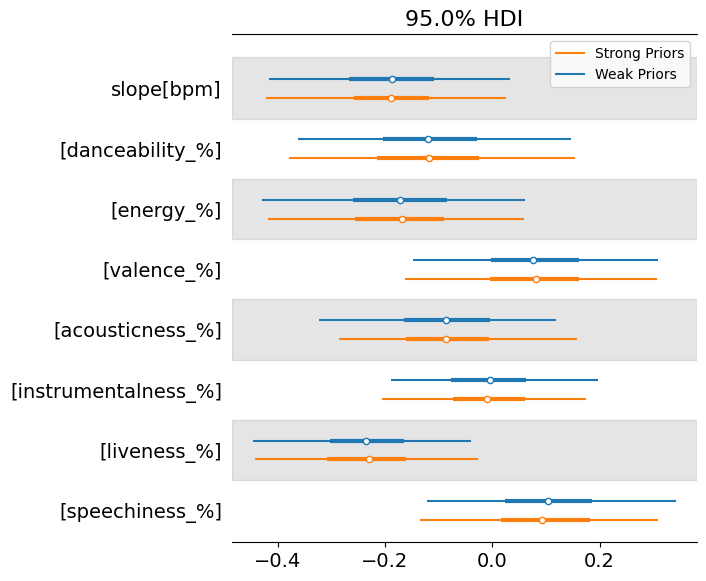

In [194]:
az.plot_forest(
    [weak_sample, strong_sample],
    model_names=["Weak Priors", "Strong Priors"],
    var_names=["slope"],
    combined=True,
    hdi_prob=0.95
)

Trace Comparison

array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

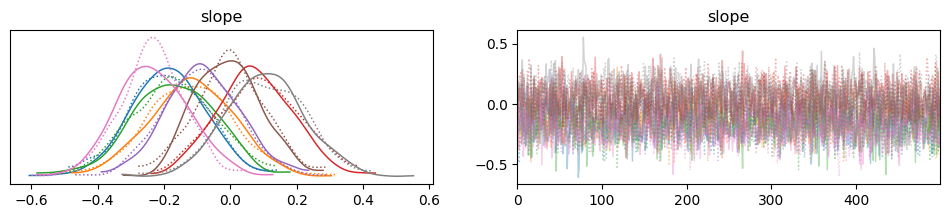

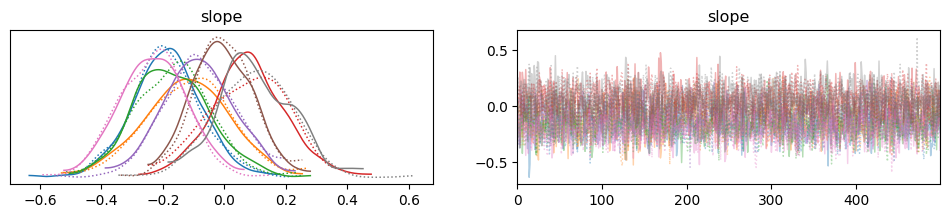

In [195]:
az.plot_trace(weak_sample, var_names=["slope"])
az.plot_trace(strong_sample, var_names=["slope"])

In [196]:
#extract slope & intercept samples
slope_samples = weak_sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = weak_sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

In [197]:
#extract slope & intercept samples
slope2_samples = strong_sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept2_samples = strong_sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n2_chains, n2_draws, n2_pred = slope2_samples.shape
slope2_flat = slope2_samples.reshape(-1, n2_pred)
intercept2_flat = intercept2_samples.flatten()

#rescale slopes back to original X and Y units
slope2_rescaled = slope2_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept2_rescaled = intercept2_flat * y.std() + y.mean() - (slope2_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior2_df = pd.DataFrame(slope2_rescaled, columns=X_multi.columns)
posterior2_df["Intercept"] = intercept2_rescaled

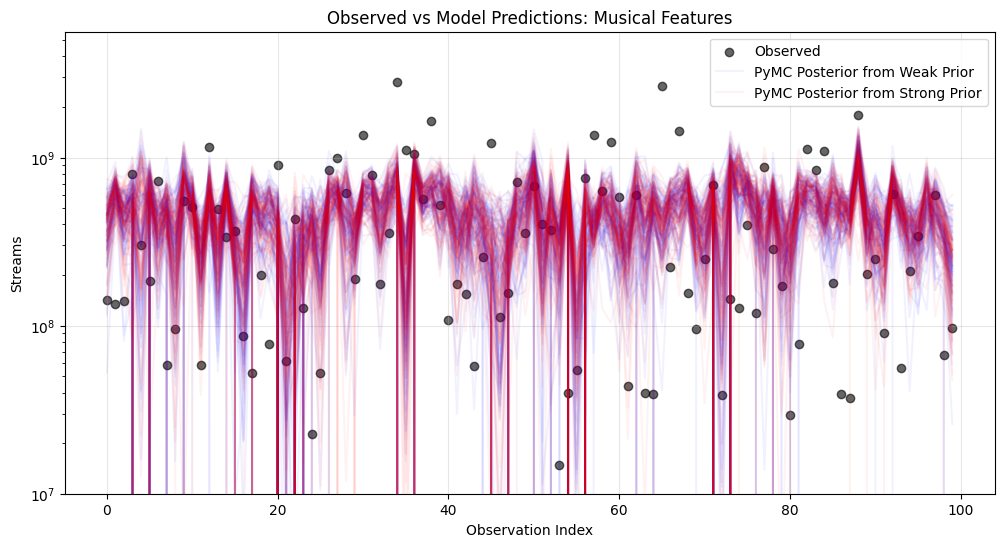

In [198]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="black", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior from Weak Prior" if idx == draw_indices[0] else "")

for idx in draw_indices:
    row = posterior2_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="red", alpha=0.05, label="PyMC Posterior from Strong Prior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
#plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
#plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
#plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [199]:
# Multivariate numeric features (no categorical, no target)
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

X_multi = df[musical_features]
y = df['streams']


In [200]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [201]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_df_lin['lin_intercept'] = lin_model.intercept_
results_df_lin['lin_r2'] = r2_score(y_test, y_pred_lin)
results_df_lin['lin_mse'] = mean_squared_error(y_test, y_pred_lin)

print(results_df_lin)


              feature      lin_coef  lin_intercept    lin_r2       lin_mse
0                 bpm -6.549595e+06   3.615634e+08 -0.020038  1.708146e+17
1      danceability_% -2.501751e+07   3.615634e+08 -0.020038  1.708146e+17
2            energy_% -3.837306e+07   3.615634e+08 -0.020038  1.708146e+17
3           valence_% -3.593877e+06   3.615634e+08 -0.020038  1.708146e+17
4      acousticness_% -6.887310e+06   3.615634e+08 -0.020038  1.708146e+17
5  instrumentalness_% -4.689885e+06   3.615634e+08 -0.020038  1.708146e+17
6          liveness_% -1.304079e+07   3.615634e+08 -0.020038  1.708146e+17
7       speechiness_% -1.862524e+07   3.615634e+08 -0.020038  1.708146e+17


In [202]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_df_ridge['ridge_intercept'] = ridge_model.intercept_
results_df_ridge['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_df_ridge['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)

print(results_df_ridge)


              feature    ridge_coef  ridge_intercept  ridge_r2     ridge_mse
0                 bpm -6.525757e+06     3.615634e+08 -0.019973  1.708036e+17
1      danceability_% -2.495142e+07     3.615634e+08 -0.019973  1.708036e+17
2            energy_% -3.825572e+07     3.615634e+08 -0.019973  1.708036e+17
3           valence_% -3.652614e+06     3.615634e+08 -0.019973  1.708036e+17
4      acousticness_% -6.804047e+06     3.615634e+08 -0.019973  1.708036e+17
5  instrumentalness_% -4.679484e+06     3.615634e+08 -0.019973  1.708036e+17
6          liveness_% -1.302431e+07     3.615634e+08 -0.019973  1.708036e+17
7       speechiness_% -1.859787e+07     3.615634e+08 -0.019973  1.708036e+17


In [203]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_df_lasso['lasso_intercept'] = lasso_model.intercept_
results_df_lasso['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_df_lasso['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)

print(results_df_lasso)


              feature    lasso_coef  lasso_intercept  lasso_r2     lasso_mse
0                 bpm -6.549595e+06     3.615634e+08 -0.020038  1.708146e+17
1      danceability_% -2.501751e+07     3.615634e+08 -0.020038  1.708146e+17
2            energy_% -3.837306e+07     3.615634e+08 -0.020038  1.708146e+17
3           valence_% -3.593877e+06     3.615634e+08 -0.020038  1.708146e+17
4      acousticness_% -6.887310e+06     3.615634e+08 -0.020038  1.708146e+17
5  instrumentalness_% -4.689885e+06     3.615634e+08 -0.020038  1.708146e+17
6          liveness_% -1.304079e+07     3.615634e+08 -0.020038  1.708146e+17
7       speechiness_% -1.862524e+07     3.615634e+08 -0.020038  1.708146e+17


In [204]:
results_musical = results_df_lin.merge(results_df_ridge, on='feature')
results_musical = results_musical.merge(results_df_lasso, on='feature')

results_musical


feature      lin_coef  lin_intercept    lin_r2       lin_mse  \
0                 bpm -6.549595e+06   3.615634e+08 -0.020038  1.708146e+17   
1      danceability_% -2.501751e+07   3.615634e+08 -0.020038  1.708146e+17   
2            energy_% -3.837306e+07   3.615634e+08 -0.020038  1.708146e+17   
3           valence_% -3.593877e+06   3.615634e+08 -0.020038  1.708146e+17   
4      acousticness_% -6.887310e+06   3.615634e+08 -0.020038  1.708146e+17   
5  instrumentalness_% -4.689885e+06   3.615634e+08 -0.020038  1.708146e+17   
6          liveness_% -1.304079e+07   3.615634e+08 -0.020038  1.708146e+17   
7       speechiness_% -1.862524e+07   3.615634e+08 -0.020038  1.708146e+17   

     ridge_coef  ridge_intercept  ridge_r2     ridge_mse    lasso_coef  \
0 -6.525757e+06     3.615634e+08 -0.019973  1.708036e+17 -6.549595e+06   
1 -2.495142e+07     3.615634e+08 -0.019973  1.708036e+17 -2.501751e+07   
2 -3.825572e+07     3.615634e+08 -0.019973  1.708036e+17 -3.837306e+07   
3 -3.652614e+06     3.615634e+08 -0.019973  1.708036e+17 -3.593877e+06   
4 -6.804047e+06     3.615634e+08 -0.019973  1.708036e+17 -6.887310e+06   
5 -4.679484e+06     3.615634e+08 -0.019973  1.708036e+17 -4.689885e+06   
6 -1.302431e+07     3.615634e+08 -0.019973  1.708036e+17 -1.304079e+07   
7 -1.859787e+07     3.615634e+08 -0.019973  1.708036e+17 -1.862524e+07   

   lasso_intercept  lasso_r2     lasso_mse  
0     3.615634e+08 -0.020038  1.708146e+17  
1     3.615634e+08 -0.020038  1.708146e+17  
2     3.615634e+08 -0.020038  1.708146e+17  
3     3.615634e+08 -0.020038  1.708146e+17  
4     3.615634e+08 -0.020038  1.708146e+17  
5     3.615634e+08 -0.020038  1.708146e+17  
6     3.615634e+08 -0.020038  1.708146e+17  
7     3.615634e+08 -0.020038  1.708146e+17

In [205]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()

Weak Prior 

In [206]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_musical_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=1e6)
    slope = pm.Normal("slope", mu=0, sigma=5e5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=1e6)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    weak_sample = pm.sample(draws=500, tune=500, chains=2, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 248 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [207]:
az.summary(weak_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.002  0.035  -0.060    0.068      0.001    0.001   
slope[bpm]                 0.016  0.037  -0.060    0.079      0.001    0.002   
slope[danceability_%]     -0.050  0.044  -0.141    0.023      0.001    0.002   
slope[energy_%]           -0.059  0.048  -0.157    0.022      0.001    0.001   
slope[valence_%]          -0.039  0.044  -0.117    0.045      0.001    0.001   
slope[acousticness_%]     -0.033  0.046  -0.115    0.056      0.001    0.001   
slope[instrumentalness_%] -0.014  0.039  -0.083    0.058      0.001    0.002   
slope[liveness_%]         -0.038  0.036  -0.106    0.022      0.001    0.001   
slope[speechiness_%]      -0.080  0.036  -0.151   -0.017      0.001    0.001   
sigma                      0.998  0.027   0.951    1.049      0.001    0.001   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1321.0     731.0   1.00  
slope[bpm]                   1665.0     509.0   1.02  
slope[danceability_%]        1289.0     813.0   1.00  
slope[energy_%]              1164.0     912.0   1.00  
slope[valence_%]             1310.0     854.0   1.00  
slope[acousticness_%]        1273.0     708.0   1.00  
slope[instrumentalness_%]    1778.0     656.0   1.01  
slope[liveness_%]            1743.0     886.0   1.00  
slope[speechiness_%]         1470.0     910.0   1.00  
sigma                        2015.0     668.0   1.00

Strong Prior 

In [208]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_strong_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_scaled.values, slope)

    likelihood = pm.Normal(
        "streams",
        mu=mu,
        sigma=sigma,
        observed=y_scaled
    )

    strong_sample = pm.sample(
        draws=500, tune=500, chains=2, random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 199 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [209]:
az.summary(strong_sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.001  0.037  -0.066    0.068      0.001    0.001   
slope[bpm]                 0.016  0.038  -0.053    0.087      0.001    0.001   
slope[danceability_%]     -0.053  0.044  -0.133    0.028      0.001    0.001   
slope[energy_%]           -0.058  0.047  -0.143    0.031      0.001    0.001   
slope[valence_%]          -0.037  0.044  -0.115    0.048      0.001    0.001   
slope[acousticness_%]     -0.031  0.044  -0.114    0.050      0.001    0.001   
slope[instrumentalness_%] -0.017  0.037  -0.083    0.056      0.001    0.001   
slope[liveness_%]         -0.039  0.036  -0.100    0.032      0.001    0.001   
slope[speechiness_%]      -0.079  0.038  -0.146   -0.006      0.001    0.001   
sigma                      0.998  0.026   0.952    1.047      0.001    0.001   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1722.0     883.0   1.00  
slope[bpm]                   1617.0     502.0   1.00  
slope[danceability_%]        1317.0     827.0   1.00  
slope[energy_%]              1263.0     942.0   1.00  
slope[valence_%]             1195.0     804.0   1.00  
slope[acousticness_%]        1377.0     964.0   1.00  
slope[instrumentalness_%]    1380.0     710.0   1.00  
slope[liveness_%]            1819.0     721.0   1.00  
slope[speechiness_%]         1487.0     697.0   1.00  
sigma                        1799.0     771.0   1.01

Forest Plot

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

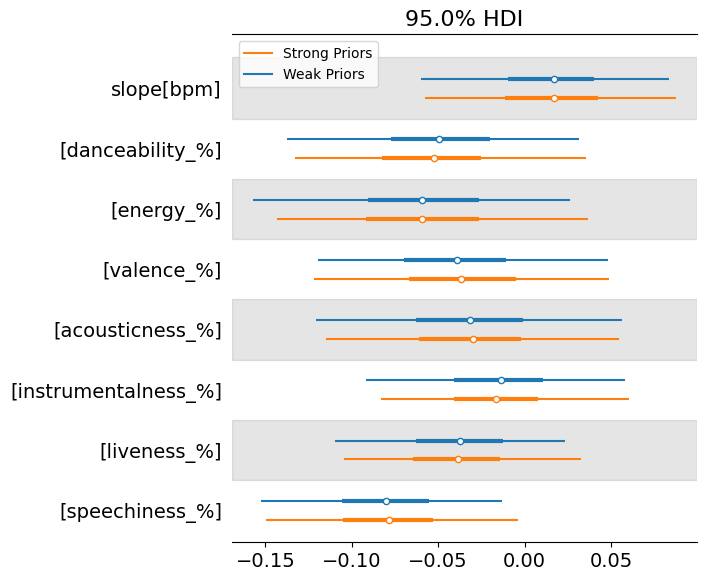

In [215]:
az.plot_forest(
    [weak_sample, strong_sample],
    model_names=["Weak Priors", "Strong Priors"],
    var_names=["slope"],
    combined=True,
    hdi_prob=0.95
)

Trace Comparison

array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

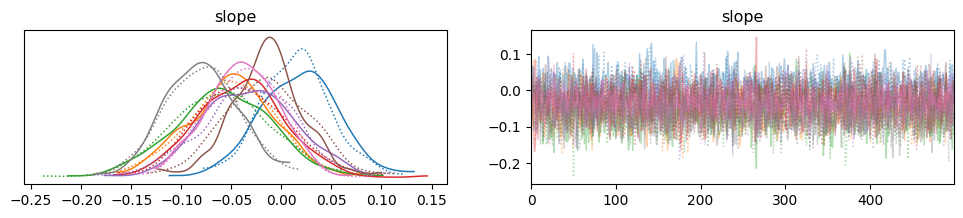

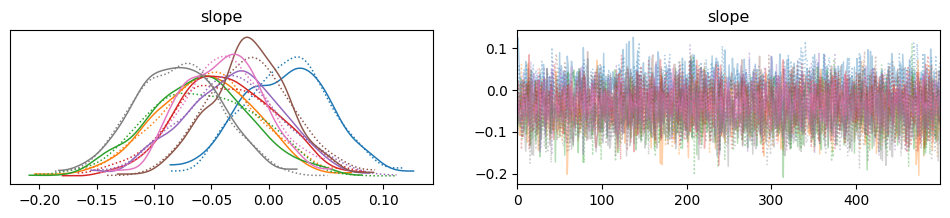

In [211]:
az.plot_trace(weak_sample, var_names=["slope"])
az.plot_trace(strong_sample, var_names=["slope"])

In [212]:
#extract slope & intercept samples
slope_samples = weak_sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = weak_sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

In [213]:
#extract slope & intercept samples
slope2_samples = strong_sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept2_samples = strong_sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n2_chains, n2_draws, n2_pred = slope2_samples.shape
slope2_flat = slope2_samples.reshape(-1, n2_pred)
intercept2_flat = intercept2_samples.flatten()

#rescale slopes back to original X and Y units
slope2_rescaled = slope2_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept2_rescaled = intercept2_flat * y.std() + y.mean() - (slope2_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior2_df = pd.DataFrame(slope2_rescaled, columns=X_multi.columns)
posterior2_df["Intercept"] = intercept2_rescaled

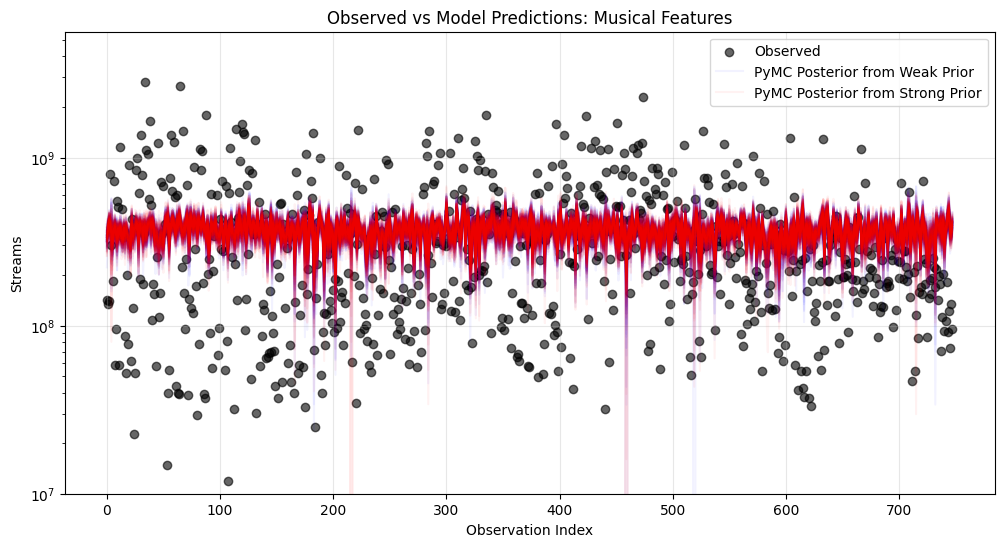

In [214]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="black", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior from Weak Prior" if idx == draw_indices[0] else "")

for idx in draw_indices:
    row = posterior2_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="red", alpha=0.05, label="PyMC Posterior from Strong Prior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
#plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
#plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
#plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if the number of times songs appear in playlists impact the number of streams with musical features in a reduced dataset of size 100 (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [216]:
df_reduced=df[0:100]

x_mvar_numeric=df_reduced.drop(columns=['track_name','artist(s)_name','key','mode','day_of_week','Full Key','streams'
                                ,'released_month','released_year','released_day'])
y=df_reduced['streams']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_model = LinearRegression()
lin_model.fit(X_train_scaled,y_train)
y_pred = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
    'lin_intercept': lin_model.intercept_,
    'lin_r2': r2_score(y_test, y_pred),
    'lin_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lin)

                 feature      lin_coef  lin_intercept    lin_r2       lin_mse
0           artist_count -8.900242e+06   4.613622e+08  0.737774  4.220826e+16
1   in_spotify_playlists  4.545699e+08   4.613622e+08  0.737774  4.220826e+16
2      in_spotify_charts  4.412633e+07   4.613622e+08  0.737774  4.220826e+16
3     in_apple_playlists  3.107992e+08   4.613622e+08  0.737774  4.220826e+16
4        in_apple_charts -2.893847e+07   4.613622e+08  0.737774  4.220826e+16
5    in_deezer_playlists -2.446843e+08   4.613622e+08  0.737774  4.220826e+16
6       in_deezer_charts  1.286526e+07   4.613622e+08  0.737774  4.220826e+16
7       in_shazam_charts -1.153981e+08   4.613622e+08  0.737774  4.220826e+16
8                    bpm  1.335389e+07   4.613622e+08  0.737774  4.220826e+16
9         danceability_%  7.918097e+06   4.613622e+08  0.737774  4.220826e+16
10             valence_% -7.349567e+06   4.613622e+08  0.737774  4.220826e+16
11              energy_% -5.272856e+07   4.613622e+08  0.737774 

In [218]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled,y_train)
y_pred = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
    'ridge_intercept': ridge_model.intercept_,
    'ridge_r2': r2_score(y_test, y_pred),
    'ridge_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_ridge)

                 feature    ridge_coef  ridge_intercept  ridge_r2  \
0           artist_count -9.451850e+06     4.613622e+08  0.774105   
1   in_spotify_playlists  3.869478e+08     4.613622e+08  0.774105   
2      in_spotify_charts  4.266871e+07     4.613622e+08  0.774105   
3     in_apple_playlists  2.800999e+08     4.613622e+08  0.774105   
4        in_apple_charts -2.538465e+07     4.613622e+08  0.774105   
5    in_deezer_playlists -1.556443e+08     4.613622e+08  0.774105   
6       in_deezer_charts  8.665116e+06     4.613622e+08  0.774105   
7       in_shazam_charts -1.144117e+08     4.613622e+08  0.774105   
8                    bpm  4.736319e+06     4.613622e+08  0.774105   
9         danceability_%  3.118242e+06     4.613622e+08  0.774105   
10             valence_% -4.861687e+06     4.613622e+08  0.774105   
11              energy_% -5.715092e+07     4.613622e+08  0.774105   
12        acousticness_% -1.001859e+07     4.613622e+08  0.774105   
13    instrumentalness_% -9.477691

In [219]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso()
lasso_model.fit(X_train_scaled,y_train)
y_pred = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
    'lasso_intercept': lasso_model.intercept_,
    'lasso_r2': r2_score(y_test, y_pred),
    'lasso_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lasso)

                 feature    lasso_coef  lasso_intercept  lasso_r2  \
0           artist_count -8.900241e+06     4.613622e+08  0.737774   
1   in_spotify_playlists  4.545698e+08     4.613622e+08  0.737774   
2      in_spotify_charts  4.412633e+07     4.613622e+08  0.737774   
3     in_apple_playlists  3.107992e+08     4.613622e+08  0.737774   
4        in_apple_charts -2.893847e+07     4.613622e+08  0.737774   
5    in_deezer_playlists -2.446843e+08     4.613622e+08  0.737774   
6       in_deezer_charts  1.286526e+07     4.613622e+08  0.737774   
7       in_shazam_charts -1.153981e+08     4.613622e+08  0.737774   
8                    bpm  1.335389e+07     4.613622e+08  0.737774   
9         danceability_%  7.918093e+06     4.613622e+08  0.737774   
10             valence_% -7.349564e+06     4.613622e+08  0.737774   
11              energy_% -5.272856e+07     4.613622e+08  0.737774   
12        acousticness_% -5.385684e+06     4.613622e+08  0.737774   
13    instrumentalness_% -7.472536

In [220]:
x_scaled = (x_mvar_numeric - x_mvar_numeric.mean()) / x_mvar_numeric.std()
y_scaled= (y - y.mean()) / y.std() #scale down y-values as well for faster computation time

with pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, shape=x_scaled.shape[1],dims='predictors')
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = intercept + pm.math.dot(x_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

In [221]:
with multivar_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [Intercept, sigma, slope, streams]


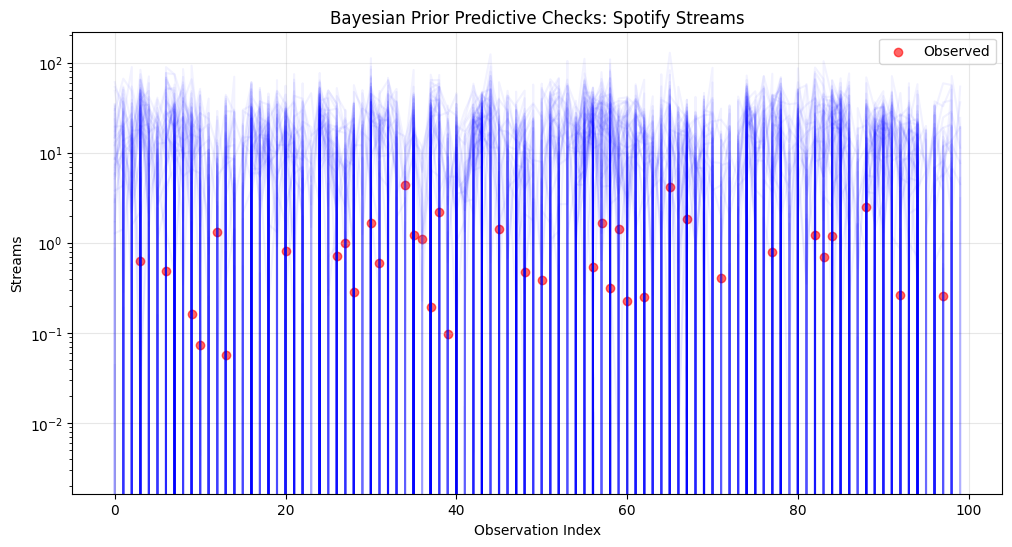

In [222]:
#prior predictive draws
prior_pred = prior_samples.prior_predictive["streams"].values  #shape: (n_draws, n_obs)

plt.figure(figsize=(12,6))

for i in range(min(100, prior_pred.shape[0])):  #plot at most 100 draws
    plt.plot(np.arange(prior_pred.shape[1]), prior_pred[i], color="blue", alpha=0.05)

#overlay observed data
plt.scatter(np.arange(len(y)), y_scaled.values, color="red", label="Observed", alpha=0.6)

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Bayesian Prior Predictive Checks: Spotify Streams")
plt.legend()
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

In [223]:
with multivar_model:
    sample=pm.sample(random_seed=42,chains=2,draws=500,tune=500,cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 67 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

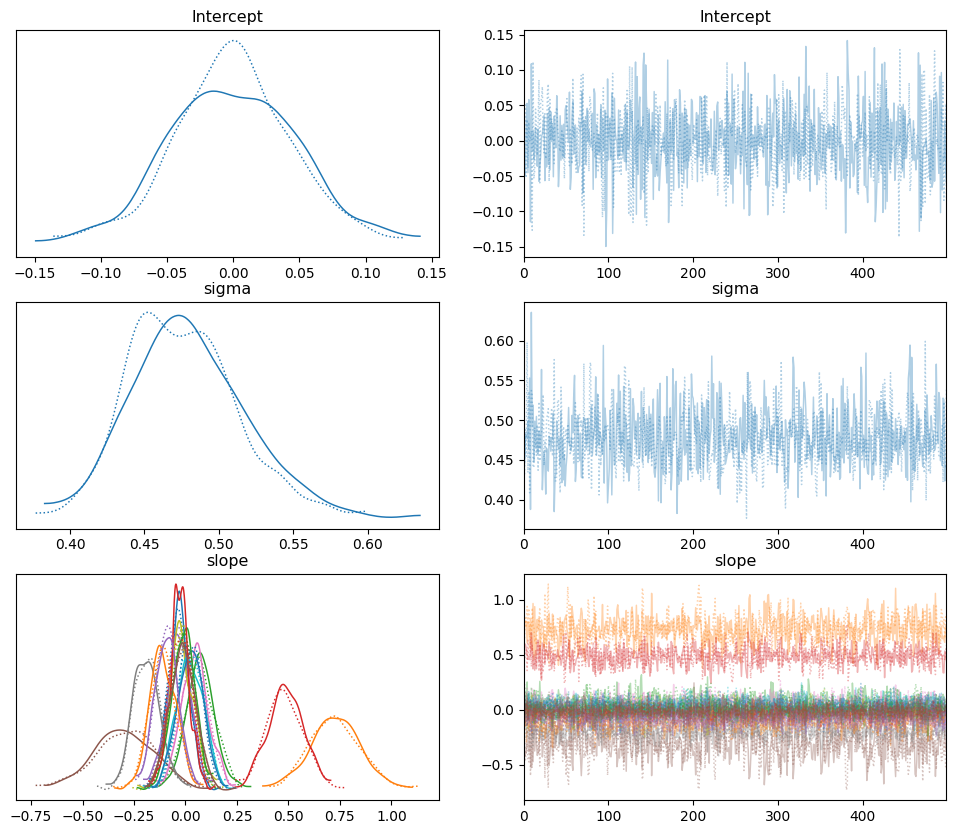

In [224]:
az.plot_trace(sample, var_names=["Intercept", "sigma", "slope"],figsize=(12,10))

Each of the densities on the left side plots look pretty similar to one another and converge to the same posterior distribution. Each of the trace plots on the right also seem to not have any general directional trend.

In [225]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                   -0.000  0.047  -0.076    0.111      0.001   
slope[artist_count]         -0.033  0.051  -0.123    0.063      0.001   
slope[in_spotify_playlists]  0.729  0.124   0.506    0.968      0.004   
slope[in_spotify_charts]     0.071  0.072  -0.070    0.204      0.002   
slope[in_apple_playlists]    0.484  0.088   0.323    0.642      0.003   
slope[in_apple_charts]      -0.032  0.059  -0.152    0.072      0.001   
slope[in_deezer_playlists]  -0.297  0.148  -0.599   -0.041      0.005   
slope[in_deezer_charts]      0.045  0.066  -0.074    0.171      0.002   
slope[in_shazam_charts]     -0.189  0.067  -0.297   -0.052      0.002   
slope[bpm]                  -0.019  0.059  -0.130    0.091      0.002   
slope[danceability_%]        0.025  0.065  -0.089    0.145      0.002   
slope[valence_%]             0.022  0.061  -0.102    0.125      0.002   
slope[energy_%]             -0.110  0.065  -0.223    0.016      0.002   
slope[acousticness_%]       -0.011  0.055  -0.116    0.087      0.002   
slope[instrumentalness_%]   -0.027  0.050  -0.124    0.066      0.001   
slope[liveness_%]           -0.092  0.055  -0.200    0.008      0.001   
slope[speechiness_%]        -0.014  0.061  -0.131    0.098      0.002   
sigma                        0.478  0.037   0.411    0.550      0.001   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                      0.002    1533.0     701.0   1.01  
slope[artist_count]            0.001    1255.0     771.0   1.00  
slope[in_spotify_playlists]    0.004     962.0     634.0   1.00  
slope[in_spotify_charts]       0.002    1014.0     817.0   1.00  
slope[in_apple_playlists]      0.003    1086.0     816.0   1.00  
slope[in_apple_charts]         0.002    1570.0     866.0   1.00  
slope[in_deezer_playlists]     0.004     792.0     695.0   1.00  
slope[in_deezer_charts]        0.002    1192.0     842.0   1.00  
slope[in_shazam_charts]        0.002    1185.0     812.0   1.00  
slope[bpm]                     0.002    1080.0     756.0   1.00  
slope[danceability_%]          0.002     964.0     823.0   1.00  
slope[valence_%]               0.002    1113.0     756.0   1.00  
slope[energy_%]                0.002    1059.0     841.0   1.00  
slope[acousticness_%]          0.002    1221.0     880.0   1.00  
slope[instrumentalness_%]      0.002    1720.0     758.0   1.01  
slope[liveness_%]              0.002    1662.0     936.0   1.00  
slope[speechiness_%]           0.002     947.0     746.0   1.00  
sigma                          0.001    1128.0     721.0   1.00

Like in other analyses, the feature "in_spotify_playlists" seems to have the biggest posterior mean in bayesian linear regression. This makes sense since the number of streams is tracked on Spotify. However, the feature "in_shazam_charts" seem to be fairly sizeable and negative, which means that more shazam charts can result in less spotify streams. This could be because if that app is used more it can drive traffic away from Spotify, resulting in less streams, or some other interdependent reason.

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

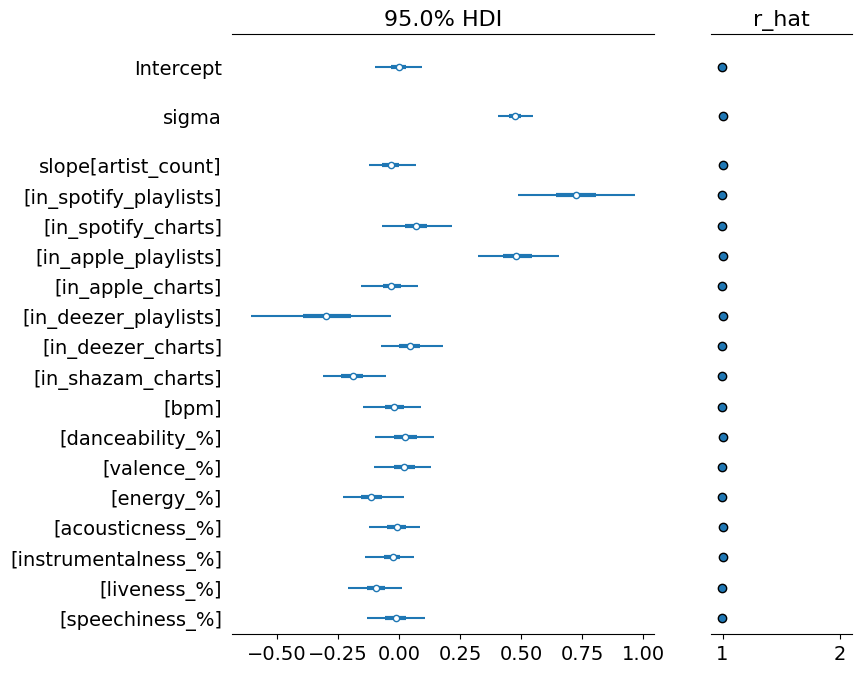

In [226]:
az.plot_forest(sample, var_names=["Intercept", "sigma", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

In [227]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / x_mvar_numeric.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * x_mvar_numeric.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=x_mvar_numeric.columns)
posterior_df["Intercept"] = intercept_rescaled

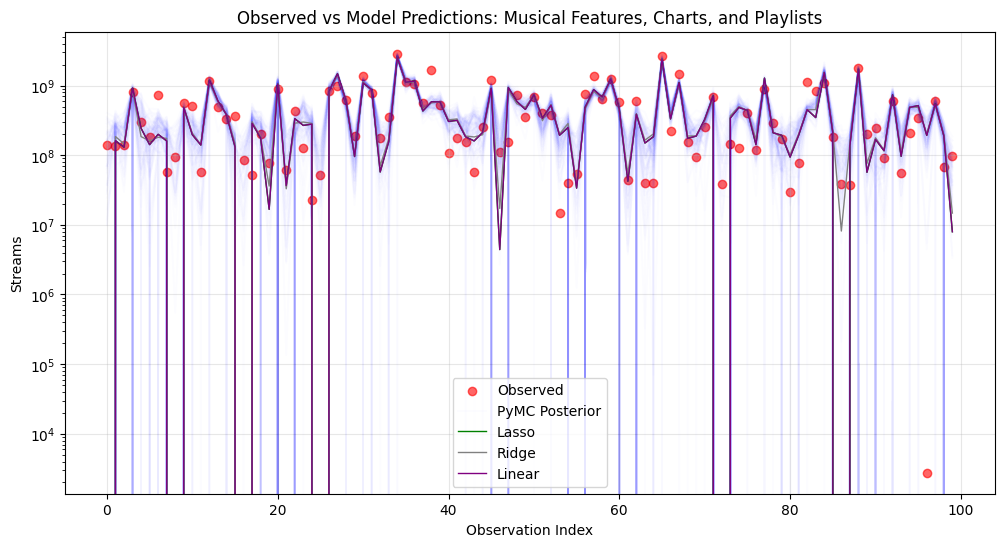

In [240]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(x_mvar_numeric.values, row[x_mvar_numeric.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(x_mvar_numeric)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features, Charts, and Playlists")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


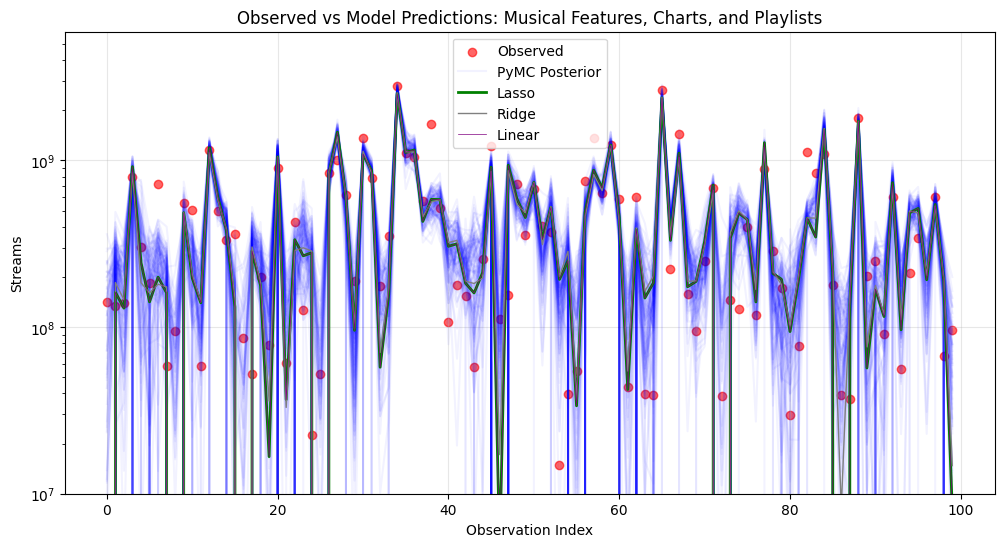

In [229]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(x_mvar_numeric.values, row[x_mvar_numeric.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(x_mvar_numeric)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features, Charts, and Playlists")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The regression models seem to line up with each other when plotted, which makes sense since the priors are weakly informative and there are not enough features for regularization effects to occur.

In [230]:
"""
#choose a spotify range
x_feature = np.linspace(x_mvar_numeric["in_spotify_playlists"].min(),
                        x_mvar_numeric["in_spotify_playlists"].max(), 100)

#other features fixed at mean
X_fixed = x_mvar_numeric.mean().values  #shape: (n_features,)

#extract posterior slopes and intercepts
intercepts = posterior_df["Intercept"].values  #shape: (n_draws,)
slopes = posterior_df[x_mvar_numeric.columns].values  #shape: (n_draws, n_features)

plt.figure(figsize=(8,6))

#plot posterior predictive lines for the Spotify feature
for i in range(len(intercepts)):
    y_pred = intercepts[i] + slopes[i] @ X_fixed  #start with mean of other features
    #vary only Spotify playlists
    y_line = y_pred + slopes[i, x_mvar_numeric.columns.get_loc("in_spotify_playlists")] * (x_feature - X_fixed[x_mvar_numeric.columns.get_loc("in_spotify_playlists")])
    plt.plot(x_feature, y_line, color="blue", alpha=0.05)

#plot observed data for reference
plt.scatter(x_mvar_numeric["in_spotify_playlists"], y.values, color="red", alpha=0.5, label="Observed")

#regression lines from single-variable regression based on spotify playlists vs streams
plt.plot(X_test_sorted, y_pred_lin_sorted, color='black', label='Linear Regression',lw=5)
plt.plot(X_test_sorted, y_pred_ridge_sorted, color='green', label='Ridge Regression',lw=3)
plt.plot(X_test_sorted, y_pred_lasso_sorted, color='purple', label='Lasso Regression')

plt.xlabel("Spotify Playlists")
plt.ylabel("Streams")
plt.title("Partial Dependence: Spotify Playlists")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
"""

'\n#choose a spotify range\nx_feature = np.linspace(x_mvar_numeric["in_spotify_playlists"].min(),\n                        x_mvar_numeric["in_spotify_playlists"].max(), 100)\n\n#other features fixed at mean\nX_fixed = x_mvar_numeric.mean().values  #shape: (n_features,)\n\n#extract posterior slopes and intercepts\nintercepts = posterior_df["Intercept"].values  #shape: (n_draws,)\nslopes = posterior_df[x_mvar_numeric.columns].values  #shape: (n_draws, n_features)\n\nplt.figure(figsize=(8,6))\n\n#plot posterior predictive lines for the Spotify feature\nfor i in range(len(intercepts)):\n    y_pred = intercepts[i] + slopes[i] @ X_fixed  #start with mean of other features\n    #vary only Spotify playlists\n    y_line = y_pred + slopes[i, x_mvar_numeric.columns.get_loc("in_spotify_playlists")] * (x_feature - X_fixed[x_mvar_numeric.columns.get_loc("in_spotify_playlists")])\n    plt.plot(x_feature, y_line, color="blue", alpha=0.05)\n\n#plot observed data for reference\nplt.scatter(x_mvar_numeri

# Multivariate Regression

This portion of the analysis sees if the number of times songs appear in playlists impact the number of streams with musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [241]:
x_mvar_numeric=df.drop(columns=['track_name','artist(s)_name','key','mode','day_of_week','Full Key','streams'
                                ,'released_month','released_year','released_day'])
y=df['streams']

In [242]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_model = LinearRegression()
lin_model.fit(X_train_scaled,y_train)
y_pred = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
    'lin_intercept': lin_model.intercept_,
    'lin_r2': r2_score(y_test, y_pred),
    'lin_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lin)

                 feature      lin_coef  lin_intercept    lin_r2       lin_mse
0           artist_count -2.071443e+07   3.615634e+08  0.710059  4.855314e+16
1   in_spotify_playlists  1.203111e+08   3.615634e+08  0.710059  4.855314e+16
2      in_spotify_charts  8.185659e+07   3.615634e+08  0.710059  4.855314e+16
3     in_apple_playlists  5.602890e+07   3.615634e+08  0.710059  4.855314e+16
4        in_apple_charts  8.518575e+06   3.615634e+08  0.710059  4.855314e+16
5    in_deezer_playlists  1.090492e+08   3.615634e+08  0.710059  4.855314e+16
6       in_deezer_charts  5.965013e+06   3.615634e+08  0.710059  4.855314e+16
7       in_shazam_charts -7.308259e+07   3.615634e+08  0.710059  4.855314e+16
8                    bpm  9.842441e+05   3.615634e+08  0.710059  4.855314e+16
9         danceability_% -1.916403e+06   3.615634e+08  0.710059  4.855314e+16
10             valence_% -9.366195e+06   3.615634e+08  0.710059  4.855314e+16
11              energy_% -1.764045e+07   3.615634e+08  0.710059 

In [243]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled,y_train)
y_pred = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
    'ridge_intercept': ridge_model.intercept_,
    'ridge_r2': r2_score(y_test, y_pred),
    'ridge_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_ridge)

                 feature    ridge_coef  ridge_intercept  ridge_r2  \
0           artist_count -2.067504e+07     3.615634e+08  0.710124   
1   in_spotify_playlists  1.201913e+08     3.615634e+08  0.710124   
2      in_spotify_charts  8.147373e+07     3.615634e+08  0.710124   
3     in_apple_playlists  5.608777e+07     3.615634e+08  0.710124   
4        in_apple_charts  8.587793e+06     3.615634e+08  0.710124   
5    in_deezer_playlists  1.089080e+08     3.615634e+08  0.710124   
6       in_deezer_charts  6.046076e+06     3.615634e+08  0.710124   
7       in_shazam_charts -7.278151e+07     3.615634e+08  0.710124   
8                    bpm  9.654966e+05     3.615634e+08  0.710124   
9         danceability_% -1.919841e+06     3.615634e+08  0.710124   
10             valence_% -9.355210e+06     3.615634e+08  0.710124   
11              energy_% -1.763115e+07     3.615634e+08  0.710124   
12        acousticness_% -1.944043e+06     3.615634e+08  0.710124   
13    instrumentalness_% -1.262383

In [244]:
X_train, X_test, y_train, y_test = train_test_split(x_mvar_numeric, y, test_size=0.2, random_state=42) 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso()
lasso_model.fit(X_train_scaled,y_train)
y_pred = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
    'lasso_intercept': lasso_model.intercept_,
    'lasso_r2': r2_score(y_test, y_pred),
    'lasso_mse': mean_squared_error(y_test, y_pred)
})

print(results_df_lasso)

                 feature    lasso_coef  lasso_intercept  lasso_r2  \
0           artist_count -2.071443e+07     3.615634e+08  0.710059   
1   in_spotify_playlists  1.203111e+08     3.615634e+08  0.710059   
2      in_spotify_charts  8.185659e+07     3.615634e+08  0.710059   
3     in_apple_playlists  5.602890e+07     3.615634e+08  0.710059   
4        in_apple_charts  8.518574e+06     3.615634e+08  0.710059   
5    in_deezer_playlists  1.090492e+08     3.615634e+08  0.710059   
6       in_deezer_charts  5.965012e+06     3.615634e+08  0.710059   
7       in_shazam_charts -7.308259e+07     3.615634e+08  0.710059   
8                    bpm  9.842433e+05     3.615634e+08  0.710059   
9         danceability_% -1.916402e+06     3.615634e+08  0.710059   
10             valence_% -9.366195e+06     3.615634e+08  0.710059   
11              energy_% -1.764045e+07     3.615634e+08  0.710059   
12        acousticness_% -1.976356e+06     3.615634e+08  0.710059   
13    instrumentalness_% -1.273609

In [245]:
x_scaled = (x_mvar_numeric - x_mvar_numeric.mean()) / x_mvar_numeric.std()
y_scaled= (y - y.mean()) / y.std() #scale down y-values as well for faster computation time

with pm.Model(coords={"predictors": x_mvar_numeric.columns.values}) as multivar_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, shape=x_scaled.shape[1],dims='predictors')
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = intercept + pm.math.dot(x_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

In [246]:
with multivar_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [Intercept, sigma, slope, streams]


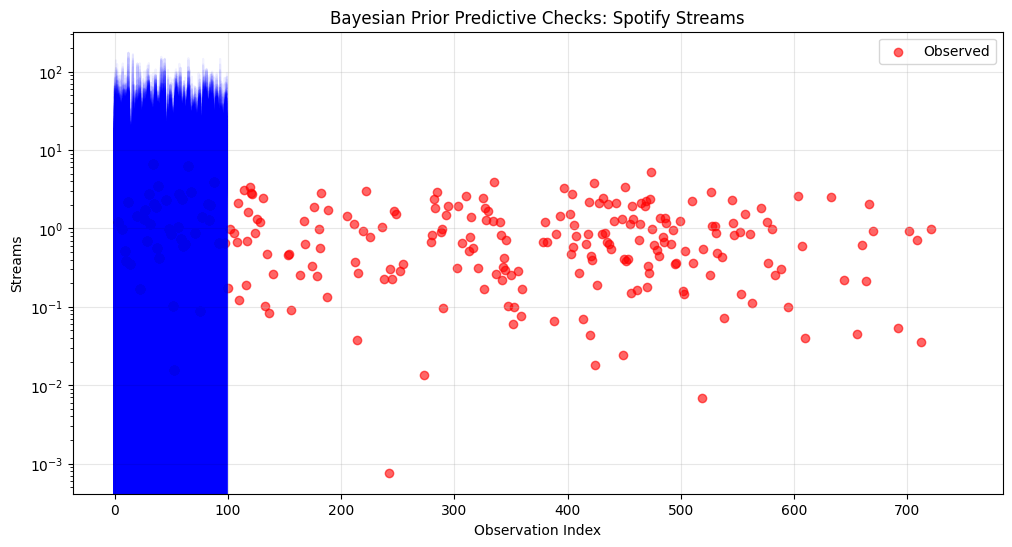

In [247]:
#prior predictive draws
prior_pred = prior_samples.prior_predictive["streams"].values  #shape: (n_draws, n_obs)

plt.figure(figsize=(12,6))

for i in range(min(100, prior_pred.shape[0])):  #plot at most 100 draws
    plt.plot(np.arange(prior_pred.shape[1]), prior_pred[i], color="blue", alpha=0.05)

#overlay observed data
plt.scatter(np.arange(len(y)), y_scaled.values, color="red", label="Observed", alpha=0.6)

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Bayesian Prior Predictive Checks: Spotify Streams")
plt.legend()
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.show()

In [248]:
with multivar_model:
    sample=pm.sample(random_seed=42,chains=2,draws=500,tune=500,cores=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 325 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

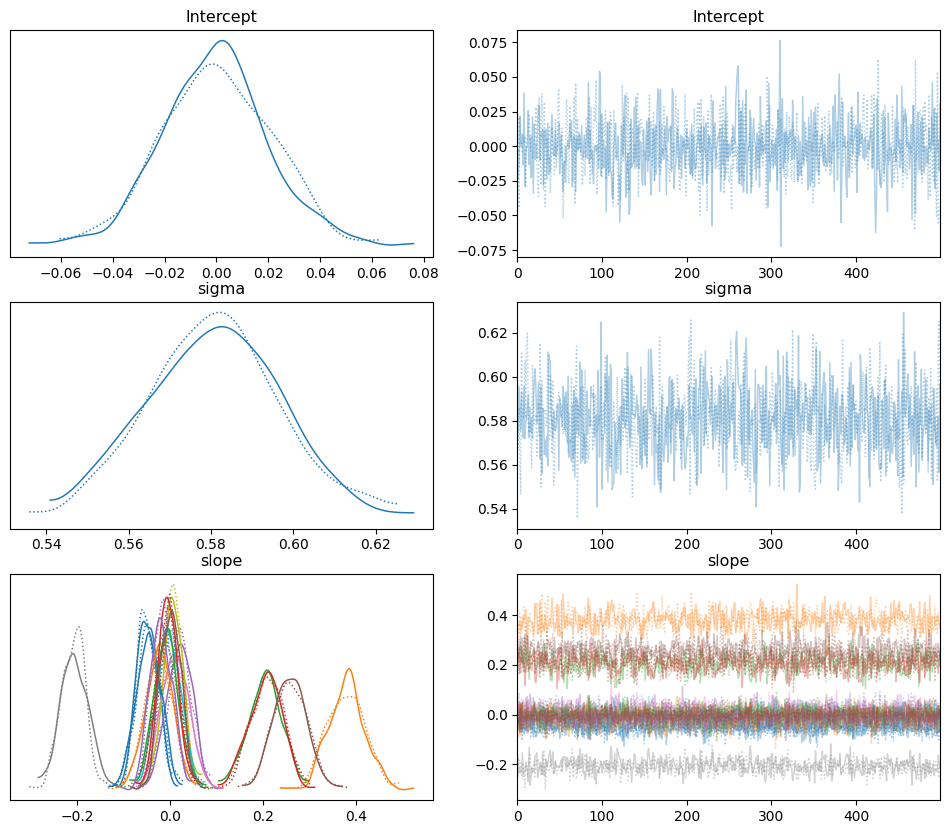

In [249]:
az.plot_trace(sample, var_names=["Intercept", "sigma", "slope"],figsize=(12,10))

Each of the densities on the left side plots look pretty similar to one another and converge to the same posterior distribution. Each of the trace plots on the right also seem to not have any general directional trend.

In [250]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                   -0.000  0.021  -0.037    0.038      0.001   
slope[artist_count]         -0.048  0.022  -0.087   -0.007      0.001   
slope[in_spotify_playlists]  0.380  0.040   0.313    0.454      0.001   
slope[in_spotify_charts]     0.207  0.035   0.136    0.267      0.001   
slope[in_apple_playlists]    0.208  0.035   0.143    0.272      0.001   
slope[in_apple_charts]       0.021  0.028  -0.033    0.067      0.001   
slope[in_deezer_playlists]   0.259  0.036   0.195    0.325      0.001   
slope[in_deezer_charts]      0.010  0.030  -0.043    0.065      0.001   
slope[in_shazam_charts]     -0.206  0.028  -0.261   -0.156      0.001   
slope[bpm]                   0.007  0.021  -0.035    0.046      0.001   
slope[danceability_%]       -0.003  0.027  -0.051    0.046      0.001   
slope[valence_%]            -0.046  0.026  -0.100   -0.003      0.001   
slope[energy_%]             -0.023  0.030  -0.079    0.031      0.001   
slope[acousticness_%]       -0.007  0.027  -0.053    0.050      0.001   
slope[instrumentalness_%]   -0.005  0.022  -0.047    0.034      0.001   
slope[liveness_%]           -0.018  0.023  -0.059    0.023      0.001   
slope[speechiness_%]         0.002  0.023  -0.039    0.042      0.001   
sigma                        0.581  0.016   0.549    0.608      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                      0.001    1294.0     857.0   1.00  
slope[artist_count]            0.001    1374.0     849.0   1.00  
slope[in_spotify_playlists]    0.001     829.0     682.0   1.00  
slope[in_spotify_charts]       0.001     783.0     641.0   1.00  
slope[in_apple_playlists]      0.001     800.0     689.0   1.00  
slope[in_apple_charts]         0.001     947.0     713.0   1.00  
slope[in_deezer_playlists]     0.001     976.0     717.0   1.00  
slope[in_deezer_charts]        0.001    1125.0     878.0   1.00  
slope[in_shazam_charts]        0.001    1012.0     867.0   1.00  
slope[bpm]                     0.001    1192.0     678.0   1.00  
slope[danceability_%]          0.001    1045.0     945.0   1.00  
slope[valence_%]               0.001    1080.0     777.0   1.00  
slope[energy_%]                0.001    1113.0     986.0   1.00  
slope[acousticness_%]          0.001     939.0     793.0   1.00  
slope[instrumentalness_%]      0.001    1376.0     672.0   1.00  
slope[liveness_%]              0.001    1593.0     935.0   1.01  
slope[speechiness_%]           0.001    1198.0     615.0   1.00  
sigma                          0.000    1178.0     799.0   1.00

Like in other analyses, the feature "in_spotify_playlists" seems to have the biggest posterior mean in bayesian linear regression. This makes sense since the number of streams is tracked on Spotify. However, the feature "in_shazam_charts" seem to be fairly sizeable and negative, which means that more shazam charts can result in less spotify streams. This could be because if that app is used more it can drive traffic away from Spotify, resulting in less streams, or some other interdependent reason.

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

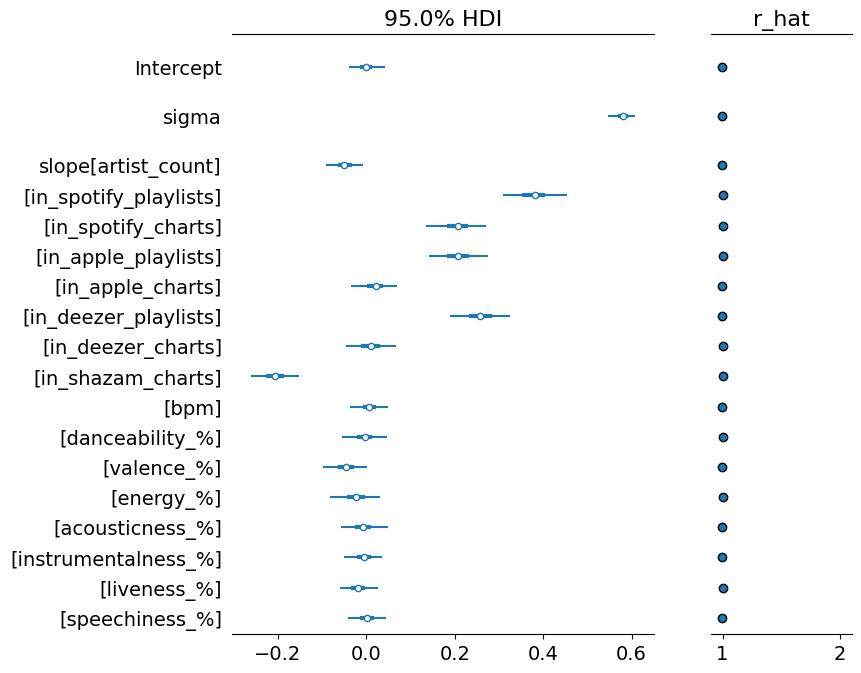

In [251]:
az.plot_forest(sample, var_names=["Intercept", "sigma", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

In [252]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / x_mvar_numeric.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * x_mvar_numeric.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=x_mvar_numeric.columns)
posterior_df["Intercept"] = intercept_rescaled

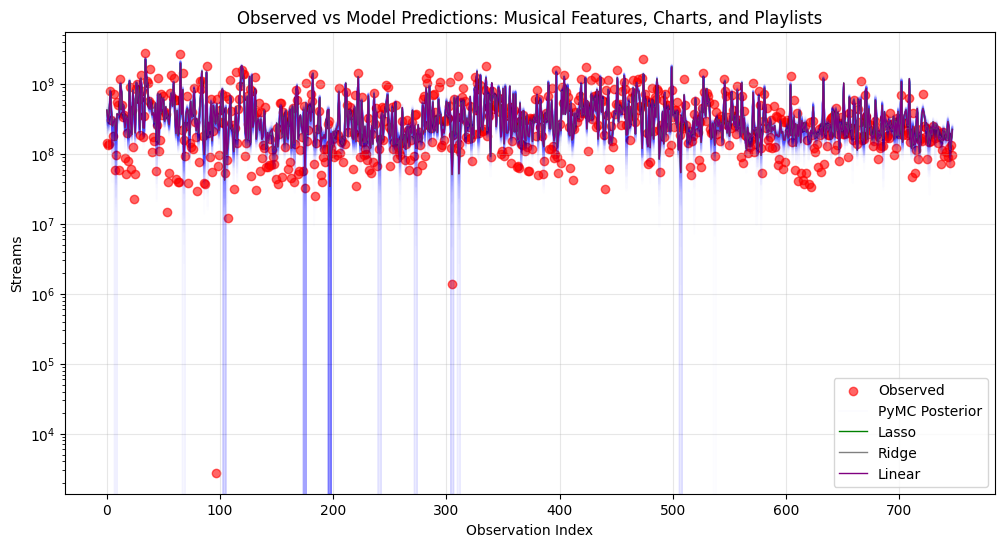

In [253]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(x_mvar_numeric.values, row[x_mvar_numeric.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(x_mvar_numeric)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features, Charts, and Playlists")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


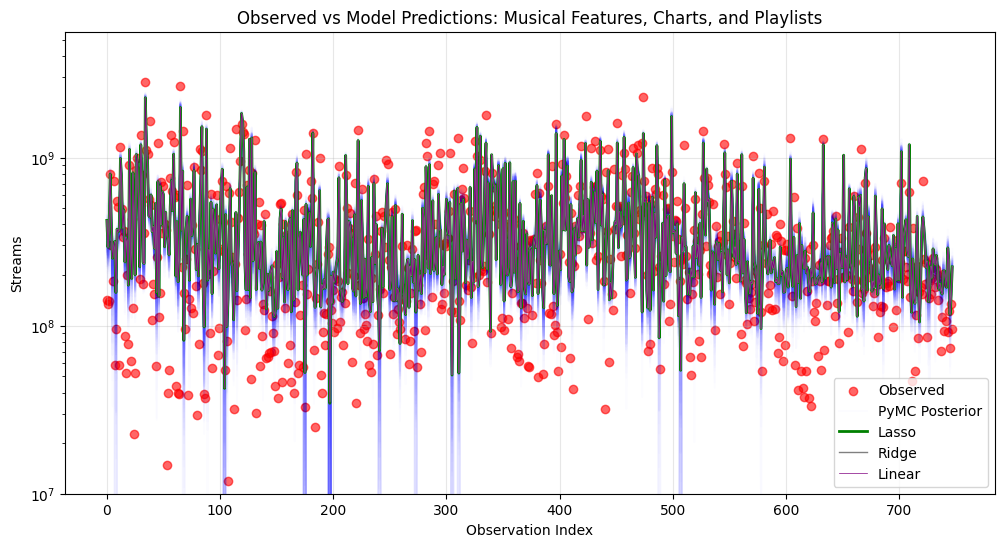

In [254]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(x_mvar_numeric.values, row[x_mvar_numeric.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(x_mvar_numeric)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features, Charts, and Playlists")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The regression models seem to line up with each other when plotted, which makes sense since the priors are weakly informative and there are not enough features for regularization effects to occur.

In [255]:
"""
#choose a spotify range
x_feature = np.linspace(x_mvar_numeric["in_spotify_playlists"].min(),
                        x_mvar_numeric["in_spotify_playlists"].max(), 100)

#other features fixed at mean
X_fixed = x_mvar_numeric.mean().values  #shape: (n_features,)

#extract posterior slopes and intercepts
intercepts = posterior_df["Intercept"].values  #shape: (n_draws,)
slopes = posterior_df[x_mvar_numeric.columns].values  #shape: (n_draws, n_features)

plt.figure(figsize=(8,6))

#plot posterior predictive lines for the Spotify feature
for i in range(len(intercepts)):
    y_pred = intercepts[i] + slopes[i] @ X_fixed  #start with mean of other features
    #vary only Spotify playlists
    y_line = y_pred + slopes[i, x_mvar_numeric.columns.get_loc("in_spotify_playlists")] * (x_feature - X_fixed[x_mvar_numeric.columns.get_loc("in_spotify_playlists")])
    plt.plot(x_feature, y_line, color="blue", alpha=0.05)

#plot observed data for reference
plt.scatter(x_mvar_numeric["in_spotify_playlists"], y.values, color="red", alpha=0.5, label="Observed")

#regression lines from single-variable regression based on spotify playlists vs streams
plt.plot(X_test_sorted, y_pred_lin_sorted, color='black', label='Linear Regression',lw=5)
plt.plot(X_test_sorted, y_pred_ridge_sorted, color='green', label='Ridge Regression',lw=3)
plt.plot(X_test_sorted, y_pred_lasso_sorted, color='purple', label='Lasso Regression')

plt.xlabel("Spotify Playlists")
plt.ylabel("Streams")
plt.title("Partial Dependence: Spotify Playlists")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
"""

'\n#choose a spotify range\nx_feature = np.linspace(x_mvar_numeric["in_spotify_playlists"].min(),\n                        x_mvar_numeric["in_spotify_playlists"].max(), 100)\n\n#other features fixed at mean\nX_fixed = x_mvar_numeric.mean().values  #shape: (n_features,)\n\n#extract posterior slopes and intercepts\nintercepts = posterior_df["Intercept"].values  #shape: (n_draws,)\nslopes = posterior_df[x_mvar_numeric.columns].values  #shape: (n_draws, n_features)\n\nplt.figure(figsize=(8,6))\n\n#plot posterior predictive lines for the Spotify feature\nfor i in range(len(intercepts)):\n    y_pred = intercepts[i] + slopes[i] @ X_fixed  #start with mean of other features\n    #vary only Spotify playlists\n    y_line = y_pred + slopes[i, x_mvar_numeric.columns.get_loc("in_spotify_playlists")] * (x_feature - X_fixed[x_mvar_numeric.columns.get_loc("in_spotify_playlists")])\n    plt.plot(x_feature, y_line, color="blue", alpha=0.05)\n\n#plot observed data for reference\nplt.scatter(x_mvar_numeri

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in a reduced dataset of size 100 and if days of the week make an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [256]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

In [257]:
df_reduced=df[0:100]

X_music = df_reduced[musical_features]
X_day = pd.get_dummies(df_reduced['day_of_week'], drop_first=True)

X_multi = pd.concat([X_music, X_day], axis=1)
y = df_reduced['streams']

In [258]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [259]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_df_lin['lin_intercept'] = lin_model.intercept_
results_df_lin['lin_r2'] = r2_score(y_test, y_pred_lin)
results_df_lin['lin_mse'] = mean_squared_error(y_test, y_pred_lin)

print(results_df_lin)

               feature      lin_coef  lin_intercept   lin_r2       lin_mse
0                  bpm -7.911767e+07   4.613622e+08 -0.27874  2.058277e+17
1       danceability_% -6.363057e+07   4.613622e+08 -0.27874  2.058277e+17
2             energy_% -5.509818e+07   4.613622e+08 -0.27874  2.058277e+17
3            valence_%  2.388175e+07   4.613622e+08 -0.27874  2.058277e+17
4       acousticness_% -5.560210e+07   4.613622e+08 -0.27874  2.058277e+17
5   instrumentalness_% -1.048046e+07   4.613622e+08 -0.27874  2.058277e+17
6           liveness_% -7.979970e+07   4.613622e+08 -0.27874  2.058277e+17
7        speechiness_%  5.854094e+07   4.613622e+08 -0.27874  2.058277e+17
8               Monday -2.950864e+07   4.613622e+08 -0.27874  2.058277e+17
9             Saturday -2.183808e+07   4.613622e+08 -0.27874  2.058277e+17
10              Sunday  6.733087e+07   4.613622e+08 -0.27874  2.058277e+17
11            Thursday -2.716626e+07   4.613622e+08 -0.27874  2.058277e+17
12             Tuesday  2

In [260]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_df_ridge['ridge_intercept'] = ridge_model.intercept_
results_df_ridge['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_df_ridge['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)

print(results_df_ridge)

               feature    ridge_coef  ridge_intercept  ridge_r2     ridge_mse
0                  bpm -7.687357e+07     4.613622e+08 -0.275773  2.053502e+17
1       danceability_% -6.079901e+07     4.613622e+08 -0.275773  2.053502e+17
2             energy_% -5.459148e+07     4.613622e+08 -0.275773  2.053502e+17
3            valence_%  2.200462e+07     4.613622e+08 -0.275773  2.053502e+17
4       acousticness_% -5.375894e+07     4.613622e+08 -0.275773  2.053502e+17
5   instrumentalness_% -1.024569e+07     4.613622e+08 -0.275773  2.053502e+17
6           liveness_% -7.857830e+07     4.613622e+08 -0.275773  2.053502e+17
7        speechiness_%  5.750382e+07     4.613622e+08 -0.275773  2.053502e+17
8               Monday -2.996812e+07     4.613622e+08 -0.275773  2.053502e+17
9             Saturday -2.174961e+07     4.613622e+08 -0.275773  2.053502e+17
10              Sunday  6.605437e+07     4.613622e+08 -0.275773  2.053502e+17
11            Thursday -2.740910e+07     4.613622e+08 -0.275773 

In [261]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_df_lasso['lasso_intercept'] = lasso_model.intercept_
results_df_lasso['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_df_lasso['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)

print(results_df_lasso)


               feature    lasso_coef  lasso_intercept  lasso_r2     lasso_mse
0                  bpm -7.911767e+07     4.613622e+08  -0.27874  2.058277e+17
1       danceability_% -6.363057e+07     4.613622e+08  -0.27874  2.058277e+17
2             energy_% -5.509818e+07     4.613622e+08  -0.27874  2.058277e+17
3            valence_%  2.388175e+07     4.613622e+08  -0.27874  2.058277e+17
4       acousticness_% -5.560210e+07     4.613622e+08  -0.27874  2.058277e+17
5   instrumentalness_% -1.048046e+07     4.613622e+08  -0.27874  2.058277e+17
6           liveness_% -7.979970e+07     4.613622e+08  -0.27874  2.058277e+17
7        speechiness_%  5.854094e+07     4.613622e+08  -0.27874  2.058277e+17
8               Monday -2.950864e+07     4.613622e+08  -0.27874  2.058277e+17
9             Saturday -2.183808e+07     4.613622e+08  -0.27874  2.058277e+17
10              Sunday  6.733087e+07     4.613622e+08  -0.27874  2.058277e+17
11            Thursday -2.716626e+07     4.613622e+08  -0.27874 

In [262]:
results_multivar = results_df_lin.merge(results_df_ridge, on='feature')
results_multivar = results_multivar.merge(results_df_lasso, on='feature')

results_multivar

feature      lin_coef  lin_intercept   lin_r2       lin_mse  \
0                  bpm -7.911767e+07   4.613622e+08 -0.27874  2.058277e+17   
1       danceability_% -6.363057e+07   4.613622e+08 -0.27874  2.058277e+17   
2             energy_% -5.509818e+07   4.613622e+08 -0.27874  2.058277e+17   
3            valence_%  2.388175e+07   4.613622e+08 -0.27874  2.058277e+17   
4       acousticness_% -5.560210e+07   4.613622e+08 -0.27874  2.058277e+17   
5   instrumentalness_% -1.048046e+07   4.613622e+08 -0.27874  2.058277e+17   
6           liveness_% -7.979970e+07   4.613622e+08 -0.27874  2.058277e+17   
7        speechiness_%  5.854094e+07   4.613622e+08 -0.27874  2.058277e+17   
8               Monday -2.950864e+07   4.613622e+08 -0.27874  2.058277e+17   
9             Saturday -2.183808e+07   4.613622e+08 -0.27874  2.058277e+17   
10              Sunday  6.733087e+07   4.613622e+08 -0.27874  2.058277e+17   
11            Thursday -2.716626e+07   4.613622e+08 -0.27874  2.058277e+17   
12             Tuesday  2.185244e+08   4.613622e+08 -0.27874  2.058277e+17   
13           Wednesday  1.175733e+07   4.613622e+08 -0.27874  2.058277e+17   

      ridge_coef  ridge_intercept  ridge_r2     ridge_mse    lasso_coef  \
0  -7.687357e+07     4.613622e+08 -0.275773  2.053502e+17 -7.911767e+07   
1  -6.079901e+07     4.613622e+08 -0.275773  2.053502e+17 -6.363057e+07   
2  -5.459148e+07     4.613622e+08 -0.275773  2.053502e+17 -5.509818e+07   
3   2.200462e+07     4.613622e+08 -0.275773  2.053502e+17  2.388175e+07   
4  -5.375894e+07     4.613622e+08 -0.275773  2.053502e+17 -5.560210e+07   
5  -1.024569e+07     4.613622e+08 -0.275773  2.053502e+17 -1.048046e+07   
6  -7.857830e+07     4.613622e+08 -0.275773  2.053502e+17 -7.979970e+07   
7   5.750382e+07     4.613622e+08 -0.275773  2.053502e+17  5.854094e+07   
8  -2.996812e+07     4.613622e+08 -0.275773  2.053502e+17 -2.950864e+07   
9  -2.174961e+07     4.613622e+08 -0.275773  2.053502e+17 -2.183808e+07   
10  6.605437e+07     4.613622e+08 -0.275773  2.053502e+17  6.733087e+07   
11 -2.740910e+07     4.613622e+08 -0.275773  2.053502e+17 -2.716626e+07   
12  2.161382e+08     4.613622e+08 -0.275773  2.053502e+17  2.185244e+08   
13  1.123031e+07     4.613622e+08 -0.275773  2.053502e+17  1.175733e+07   

    lasso_intercept  lasso_r2     lasso_mse  
0      4.613622e+08  -0.27874  2.058277e+17  
1      4.613622e+08  -0.27874  2.058277e+17  
2      4.613622e+08  -0.27874  2.058277e+17  
3      4.613622e+08  -0.27874  2.058277e+17  
4      4.613622e+08  -0.27874  2.058277e+17  
5      4.613622e+08  -0.27874  2.058277e+17  
6      4.613622e+08  -0.27874  2.058277e+17  
7      4.613622e+08  -0.27874  2.058277e+17  
8      4.613622e+08  -0.27874  2.058277e+17  
9      4.613622e+08  -0.27874  2.058277e+17  
10     4.613622e+08  -0.27874  2.058277e+17  
11     4.613622e+08  -0.27874  2.058277e+17  
12     4.613622e+08  -0.27874  2.058277e+17  
13     4.613622e+08  -0.27874  2.058277e+17

In [263]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()


In [264]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as multivar_weak_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        random_seed=42,
        chains=2,
        draws=300,
        tune=300,
        cores=2,
        target_accept=0.9
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [265]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.002  0.093  -0.149    0.192      0.003    0.004   
slope[bpm]                -0.263  0.108  -0.462   -0.062      0.004    0.004   
slope[danceability_%]     -0.114  0.124  -0.361    0.093      0.006    0.005   
slope[energy_%]           -0.094  0.128  -0.339    0.136      0.005    0.005   
slope[valence_%]           0.042  0.124  -0.188    0.275      0.005    0.005   
slope[acousticness_%]     -0.091  0.119  -0.299    0.128      0.005    0.005   
slope[instrumentalness_%] -0.005  0.105  -0.202    0.179      0.005    0.004   
slope[liveness_%]         -0.190  0.104  -0.382   -0.007      0.004    0.004   
slope[speechiness_%]       0.075  0.114  -0.174    0.268      0.006    0.005   
slope[Monday]             -0.028  0.094  -0.189    0.171      0.003    0.004   
slope[Saturday]           -0.023  0.103  -0.206    0.174      0.004    0.005   
slope[Sunday]              0.191  0.100   0.016    0.374      0.004    0.003   
slope[Thursday]            0.063  0.117  -0.176    0.260      0.004    0.005   
slope[Tuesday]             0.373  0.101   0.166    0.556      0.004    0.004   
slope[Wednesday]           0.085  0.102  -0.097    0.259      0.003    0.004   
sigma                      0.949  0.076   0.814    1.088      0.004    0.004   

                           ess_bulk  ess_tail  r_hat  
Intercept                     865.0     516.0   1.01  
slope[bpm]                    588.0     548.0   1.00  
slope[danceability_%]         428.0     330.0   1.00  
slope[energy_%]               564.0     447.0   1.00  
slope[valence_%]              673.0     577.0   1.00  
slope[acousticness_%]         561.0     416.0   1.01  
slope[instrumentalness_%]     541.0     454.0   1.00  
slope[liveness_%]             680.0     490.0   1.00  
slope[speechiness_%]          386.0     322.0   1.00  
slope[Monday]                 744.0     469.0   1.00  
slope[Saturday]               826.0     324.0   1.00  
slope[Sunday]                 529.0     402.0   1.00  
slope[Thursday]               733.0     366.0   1.01  
slope[Tuesday]                642.0     416.0   1.00  
slope[Wednesday]              870.0     387.0   1.00  
sigma                         410.0     301.0   1.00

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

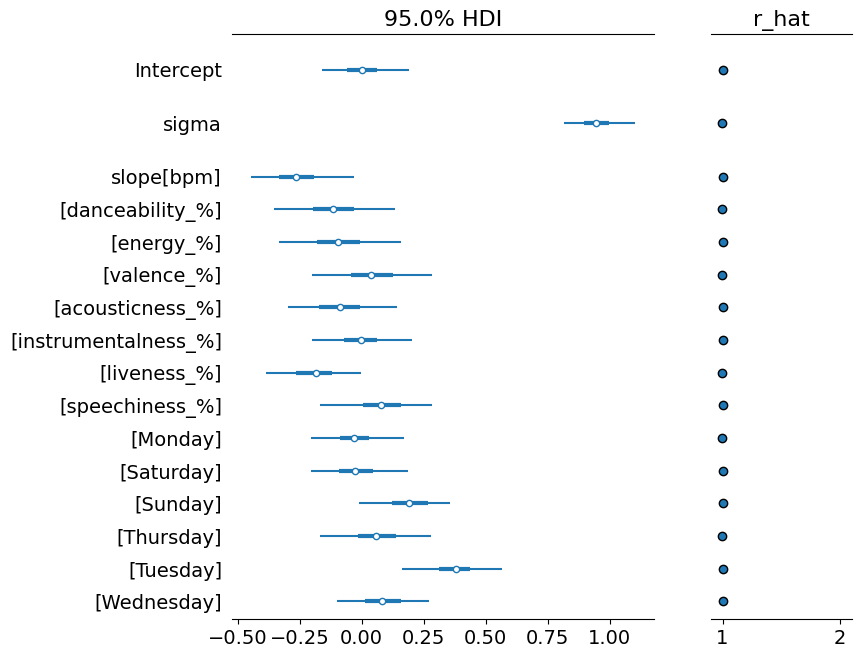

In [266]:
az.plot_forest(sample, var_names=["Intercept", "sigma", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

In [267]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

In [268]:
"""
slope_samples = sample.posterior["slope"].values
intercept_samples = sample.posterior["Intercept"].values

# flatten
slope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])
intercept_flat = intercept_samples.flatten()

# rescale
slope_rescaled = slope_flat * y.std() / X_multi.std().values
intercept_rescaled = (
    intercept_flat * y.std()
    + y.mean()
    - (slope_rescaled * X_multi.mean().values).sum(axis=1)
)

bayes_results_df = pd.DataFrame({
    'feature': X_multi.columns,
    'bayes_coef_mean': slope_rescaled.mean(axis=0),
    'bayes_coef_sd': slope_rescaled.std(axis=0),
})

bayes_results_df['bayes_intercept_mean'] = intercept_rescaled.mean()

bayes_results_df
"""

'\nslope_samples = sample.posterior["slope"].values\nintercept_samples = sample.posterior["Intercept"].values\n\n# flatten\nslope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])\nintercept_flat = intercept_samples.flatten()\n\n# rescale\nslope_rescaled = slope_flat * y.std() / X_multi.std().values\nintercept_rescaled = (\n    intercept_flat * y.std()\n    + y.mean()\n    - (slope_rescaled * X_multi.mean().values).sum(axis=1)\n)\n\nbayes_results_df = pd.DataFrame({\n    \'feature\': X_multi.columns,\n    \'bayes_coef_mean\': slope_rescaled.mean(axis=0),\n    \'bayes_coef_sd\': slope_rescaled.std(axis=0),\n})\n\nbayes_results_df[\'bayes_intercept_mean\'] = intercept_rescaled.mean()\n\nbayes_results_df\n'

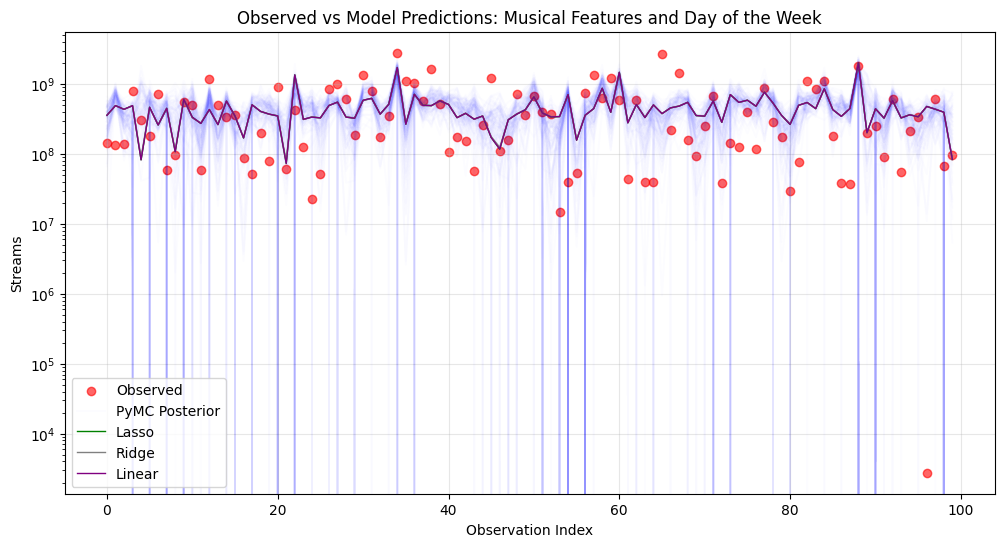

In [269]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Day of the Week")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


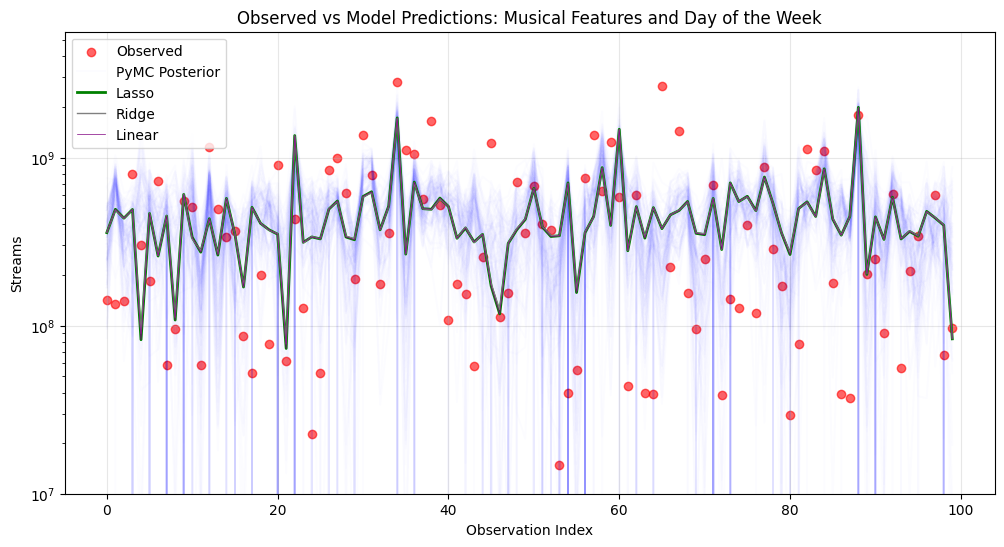

In [271]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Day of the Week")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if days of the week make an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [272]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

In [273]:
X_music = df[musical_features]
X_day = pd.get_dummies(df['day_of_week'], drop_first=True)

X_multi = pd.concat([X_music, X_day], axis=1)
y = df['streams']

In [274]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [275]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_df_lin = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_df_lin['lin_intercept'] = lin_model.intercept_
results_df_lin['lin_r2'] = r2_score(y_test, y_pred_lin)
results_df_lin['lin_mse'] = mean_squared_error(y_test, y_pred_lin)

print(results_df_lin)

               feature      lin_coef  lin_intercept    lin_r2       lin_mse
0                  bpm -8.586914e+06   3.615634e+08 -0.032057  1.728272e+17
1       danceability_% -2.579933e+07   3.615634e+08 -0.032057  1.728272e+17
2             energy_% -3.929245e+07   3.615634e+08 -0.032057  1.728272e+17
3            valence_% -5.616457e+06   3.615634e+08 -0.032057  1.728272e+17
4       acousticness_% -7.425668e+06   3.615634e+08 -0.032057  1.728272e+17
5   instrumentalness_% -5.674452e+06   3.615634e+08 -0.032057  1.728272e+17
6           liveness_% -1.437006e+07   3.615634e+08 -0.032057  1.728272e+17
7        speechiness_% -1.736301e+07   3.615634e+08 -0.032057  1.728272e+17
8               Monday -1.074744e+06   3.615634e+08 -0.032057  1.728272e+17
9             Saturday -2.589051e+06   3.615634e+08 -0.032057  1.728272e+17
10              Sunday  5.442979e+06   3.615634e+08 -0.032057  1.728272e+17
11            Thursday  2.718009e+07   3.615634e+08 -0.032057  1.728272e+17
12          

In [276]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_df_ridge = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_df_ridge['ridge_intercept'] = ridge_model.intercept_
results_df_ridge['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_df_ridge['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)

print(results_df_ridge)

               feature    ridge_coef  ridge_intercept  ridge_r2     ridge_mse
0                  bpm -8.555668e+06     3.615634e+08 -0.031953  1.728098e+17
1       danceability_% -2.572616e+07     3.615634e+08 -0.031953  1.728098e+17
2             energy_% -3.916361e+07     3.615634e+08 -0.031953  1.728098e+17
3            valence_% -5.671562e+06     3.615634e+08 -0.031953  1.728098e+17
4       acousticness_% -7.334156e+06     3.615634e+08 -0.031953  1.728098e+17
5   instrumentalness_% -5.658846e+06     3.615634e+08 -0.031953  1.728098e+17
6           liveness_% -1.434989e+07     3.615634e+08 -0.031953  1.728098e+17
7        speechiness_% -1.734283e+07     3.615634e+08 -0.031953  1.728098e+17
8               Monday -1.106101e+06     3.615634e+08 -0.031953  1.728098e+17
9             Saturday -2.599978e+06     3.615634e+08 -0.031953  1.728098e+17
10              Sunday  5.421273e+06     3.615634e+08 -0.031953  1.728098e+17
11            Thursday  2.710570e+07     3.615634e+08 -0.031953 

In [277]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_df_lasso = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_df_lasso['lasso_intercept'] = lasso_model.intercept_
results_df_lasso['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_df_lasso['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)

print(results_df_lasso)


               feature    lasso_coef  lasso_intercept  lasso_r2     lasso_mse
0                  bpm -8.586914e+06     3.615634e+08 -0.032057  1.728272e+17
1       danceability_% -2.579933e+07     3.615634e+08 -0.032057  1.728272e+17
2             energy_% -3.929245e+07     3.615634e+08 -0.032057  1.728272e+17
3            valence_% -5.616457e+06     3.615634e+08 -0.032057  1.728272e+17
4       acousticness_% -7.425668e+06     3.615634e+08 -0.032057  1.728272e+17
5   instrumentalness_% -5.674452e+06     3.615634e+08 -0.032057  1.728272e+17
6           liveness_% -1.437006e+07     3.615634e+08 -0.032057  1.728272e+17
7        speechiness_% -1.736301e+07     3.615634e+08 -0.032057  1.728272e+17
8               Monday -1.074744e+06     3.615634e+08 -0.032057  1.728272e+17
9             Saturday -2.589051e+06     3.615634e+08 -0.032057  1.728272e+17
10              Sunday  5.442979e+06     3.615634e+08 -0.032057  1.728272e+17
11            Thursday  2.718009e+07     3.615634e+08 -0.032057 

In [278]:
results_multivar = results_df_lin.merge(results_df_ridge, on='feature')
results_multivar = results_multivar.merge(results_df_lasso, on='feature')

results_multivar

feature      lin_coef  lin_intercept    lin_r2       lin_mse  \
0                  bpm -8.586914e+06   3.615634e+08 -0.032057  1.728272e+17   
1       danceability_% -2.579933e+07   3.615634e+08 -0.032057  1.728272e+17   
2             energy_% -3.929245e+07   3.615634e+08 -0.032057  1.728272e+17   
3            valence_% -5.616457e+06   3.615634e+08 -0.032057  1.728272e+17   
4       acousticness_% -7.425668e+06   3.615634e+08 -0.032057  1.728272e+17   
5   instrumentalness_% -5.674452e+06   3.615634e+08 -0.032057  1.728272e+17   
6           liveness_% -1.437006e+07   3.615634e+08 -0.032057  1.728272e+17   
7        speechiness_% -1.736301e+07   3.615634e+08 -0.032057  1.728272e+17   
8               Monday -1.074744e+06   3.615634e+08 -0.032057  1.728272e+17   
9             Saturday -2.589051e+06   3.615634e+08 -0.032057  1.728272e+17   
10              Sunday  5.442979e+06   3.615634e+08 -0.032057  1.728272e+17   
11            Thursday  2.718009e+07   3.615634e+08 -0.032057  1.728272e+17   
12             Tuesday  2.475249e+07   3.615634e+08 -0.032057  1.728272e+17   
13           Wednesday  2.316387e+07   3.615634e+08 -0.032057  1.728272e+17   

      ridge_coef  ridge_intercept  ridge_r2     ridge_mse    lasso_coef  \
0  -8.555668e+06     3.615634e+08 -0.031953  1.728098e+17 -8.586914e+06   
1  -2.572616e+07     3.615634e+08 -0.031953  1.728098e+17 -2.579933e+07   
2  -3.916361e+07     3.615634e+08 -0.031953  1.728098e+17 -3.929245e+07   
3  -5.671562e+06     3.615634e+08 -0.031953  1.728098e+17 -5.616457e+06   
4  -7.334156e+06     3.615634e+08 -0.031953  1.728098e+17 -7.425668e+06   
5  -5.658846e+06     3.615634e+08 -0.031953  1.728098e+17 -5.674452e+06   
6  -1.434989e+07     3.615634e+08 -0.031953  1.728098e+17 -1.437006e+07   
7  -1.734283e+07     3.615634e+08 -0.031953  1.728098e+17 -1.736301e+07   
8  -1.106101e+06     3.615634e+08 -0.031953  1.728098e+17 -1.074744e+06   
9  -2.599978e+06     3.615634e+08 -0.031953  1.728098e+17 -2.589051e+06   
10  5.421273e+06     3.615634e+08 -0.031953  1.728098e+17  5.442979e+06   
11  2.710570e+07     3.615634e+08 -0.031953  1.728098e+17  2.718009e+07   
12  2.469946e+07     3.615634e+08 -0.031953  1.728098e+17  2.475249e+07   
13  2.310256e+07     3.615634e+08 -0.031953  1.728098e+17  2.316387e+07   

    lasso_intercept  lasso_r2     lasso_mse  
0      3.615634e+08 -0.032057  1.728272e+17  
1      3.615634e+08 -0.032057  1.728272e+17  
2      3.615634e+08 -0.032057  1.728272e+17  
3      3.615634e+08 -0.032057  1.728272e+17  
4      3.615634e+08 -0.032057  1.728272e+17  
5      3.615634e+08 -0.032057  1.728272e+17  
6      3.615634e+08 -0.032057  1.728272e+17  
7      3.615634e+08 -0.032057  1.728272e+17  
8      3.615634e+08 -0.032057  1.728272e+17  
9      3.615634e+08 -0.032057  1.728272e+17  
10     3.615634e+08 -0.032057  1.728272e+17  
11     3.615634e+08 -0.032057  1.728272e+17  
12     3.615634e+08 -0.032057  1.728272e+17  
13     3.615634e+08 -0.032057  1.728272e+17

In [279]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()


In [280]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as multivar_weak_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        random_seed=42,
        chains=2,
        draws=300,
        tune=300,
        cores=2,
        target_accept=0.9
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 189 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [281]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 -0.002  0.033  -0.066    0.054      0.001    0.001   
slope[bpm]                 0.011  0.037  -0.067    0.072      0.001    0.002   
slope[danceability_%]     -0.055  0.046  -0.143    0.024      0.002    0.002   
slope[energy_%]           -0.065  0.050  -0.145    0.043      0.002    0.002   
slope[valence_%]          -0.040  0.045  -0.132    0.037      0.002    0.002   
slope[acousticness_%]     -0.035  0.049  -0.128    0.053      0.002    0.002   
slope[instrumentalness_%] -0.017  0.041  -0.091    0.063      0.002    0.002   
slope[liveness_%]         -0.037  0.038  -0.105    0.033      0.002    0.002   
slope[speechiness_%]      -0.076  0.038  -0.143   -0.001      0.002    0.001   
slope[Monday]              0.014  0.036  -0.049    0.083      0.002    0.001   
slope[Saturday]           -0.015  0.036  -0.071    0.060      0.001    0.001   
slope[Sunday]              0.039  0.037  -0.029    0.111      0.001    0.002   
slope[Thursday]            0.044  0.037  -0.024    0.109      0.001    0.001   
slope[Tuesday]             0.051  0.037  -0.020    0.117      0.001    0.001   
slope[Wednesday]           0.064  0.036  -0.000    0.133      0.001    0.001   
sigma                      1.000  0.027   0.954    1.050      0.001    0.001   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1012.0     458.0   1.02  
slope[bpm]                    718.0     377.0   1.00  
slope[danceability_%]         546.0     458.0   1.00  
slope[energy_%]               517.0     457.0   1.00  
slope[valence_%]              629.0     422.0   1.00  
slope[acousticness_%]         601.0     469.0   1.00  
slope[instrumentalness_%]     617.0     338.0   1.00  
slope[liveness_%]             524.0     423.0   1.01  
slope[speechiness_%]          591.0     454.0   1.00  
slope[Monday]                 558.0     424.0   1.00  
slope[Saturday]               920.0     478.0   1.00  
slope[Sunday]                 691.0     471.0   1.01  
slope[Thursday]               710.0     455.0   1.00  
slope[Tuesday]                775.0     419.0   1.00  
slope[Wednesday]             1033.0     387.0   1.00  
sigma                         657.0     421.0   1.01

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

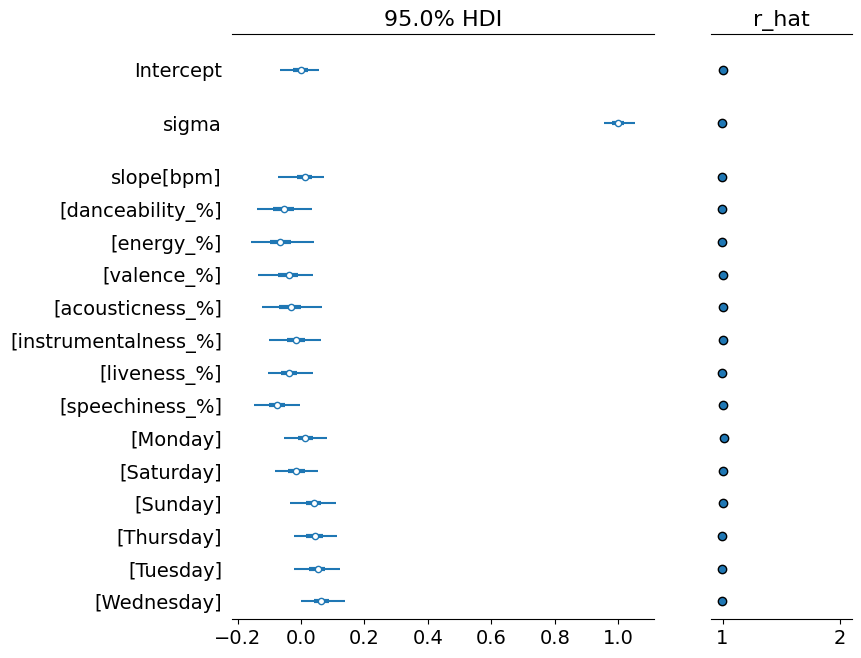

In [282]:
az.plot_forest(sample, var_names=["Intercept", "sigma", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

In [283]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

In [284]:
"""
slope_samples = sample.posterior["slope"].values
intercept_samples = sample.posterior["Intercept"].values

# flatten
slope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])
intercept_flat = intercept_samples.flatten()

# rescale
slope_rescaled = slope_flat * y.std() / X_multi.std().values
intercept_rescaled = (
    intercept_flat * y.std()
    + y.mean()
    - (slope_rescaled * X_multi.mean().values).sum(axis=1)
)

bayes_results_df = pd.DataFrame({
    'feature': X_multi.columns,
    'bayes_coef_mean': slope_rescaled.mean(axis=0),
    'bayes_coef_sd': slope_rescaled.std(axis=0),
})

bayes_results_df['bayes_intercept_mean'] = intercept_rescaled.mean()

bayes_results_df
"""

'\nslope_samples = sample.posterior["slope"].values\nintercept_samples = sample.posterior["Intercept"].values\n\n# flatten\nslope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])\nintercept_flat = intercept_samples.flatten()\n\n# rescale\nslope_rescaled = slope_flat * y.std() / X_multi.std().values\nintercept_rescaled = (\n    intercept_flat * y.std()\n    + y.mean()\n    - (slope_rescaled * X_multi.mean().values).sum(axis=1)\n)\n\nbayes_results_df = pd.DataFrame({\n    \'feature\': X_multi.columns,\n    \'bayes_coef_mean\': slope_rescaled.mean(axis=0),\n    \'bayes_coef_sd\': slope_rescaled.std(axis=0),\n})\n\nbayes_results_df[\'bayes_intercept_mean\'] = intercept_rescaled.mean()\n\nbayes_results_df\n'

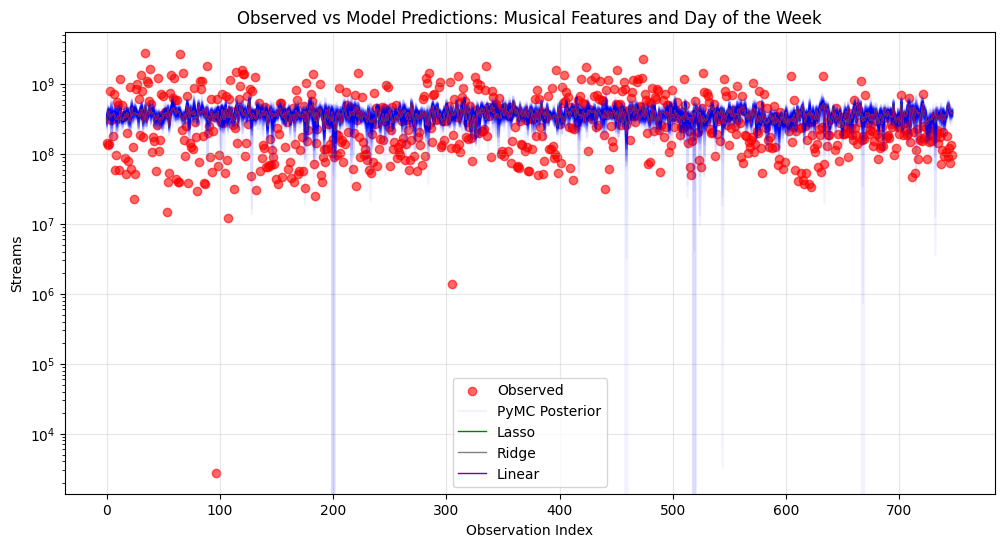

In [285]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Day of the Week")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


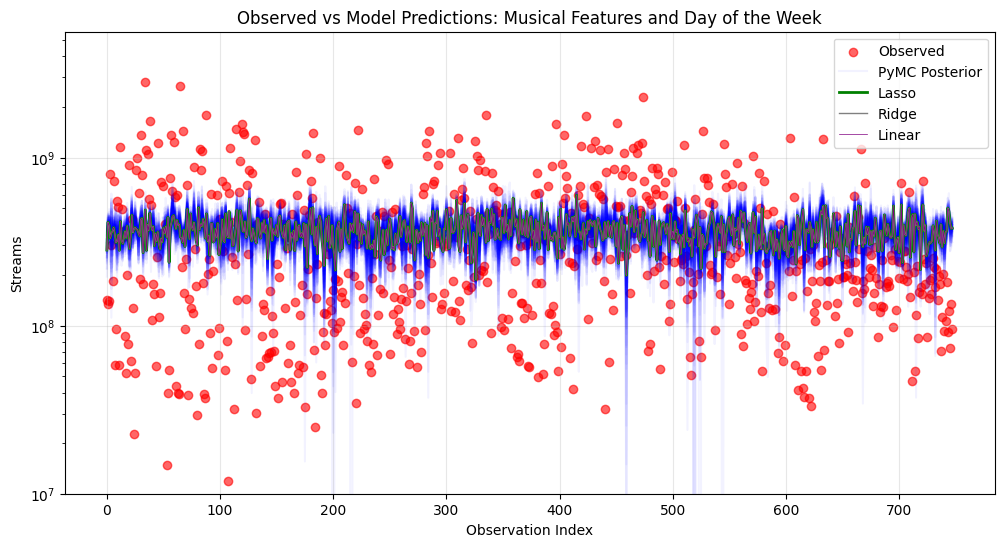

In [286]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Day of the Week")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in a reduced dataset of size 100 and if key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [287]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]
df_reduced=df[0:100]

y = df_reduced['streams']

In [288]:
X_key = pd.concat([
    df_reduced[musical_features],
    pd.get_dummies(df_reduced['key'], drop_first=True)
], axis=1)

In [289]:
X_train, X_test, y_train, y_test = train_test_split(
    X_key, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [290]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_lin_key = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_lin_key['lin_intercept'] = lin_model.intercept_
results_lin_key['lin_r2'] = r2_score(y_test, y_pred_lin)
results_lin_key['lin_mse'] = mean_squared_error(y_test, y_pred_lin)



In [291]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_ridge_key = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_ridge_key['ridge_intercept'] = ridge_model.intercept_
results_ridge_key['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_ridge_key['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)


In [292]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_lasso_key = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_lasso_key['lasso_intercept'] = lasso_model.intercept_
results_lasso_key['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_lasso_key['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)



In [293]:
X_scaled = (X_key - X_key.mean()) / X_key.std()
y_scaled = (y - y.mean()) / y.std()

with pm.Model(coords={"predictors": X_key.columns.values}) as bayes_key_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(draws=300, tune=300, chains=2, cores=2, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [294]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 -0.003  0.102  -0.178    0.193      0.003    0.006   
slope[bpm]                -0.200  0.111  -0.398    0.023      0.005    0.004   
slope[danceability_%]     -0.155  0.140  -0.398    0.104      0.007    0.006   
slope[energy_%]           -0.178  0.133  -0.391    0.091      0.006    0.005   
slope[valence_%]           0.164  0.133  -0.048    0.426      0.006    0.004   
slope[acousticness_%]     -0.036  0.126  -0.292    0.172      0.005    0.004   
slope[instrumentalness_%]  0.010  0.113  -0.193    0.221      0.006    0.005   
slope[liveness_%]         -0.255  0.114  -0.452   -0.047      0.004    0.006   
slope[speechiness_%]       0.100  0.130  -0.142    0.331      0.006    0.005   
slope[A#]                 -0.045  0.159  -0.340    0.243      0.010    0.008   
slope[B]                  -0.051  0.186  -0.399    0.264      0.012    0.008   
slope[C#]                  0.202  0.210  -0.165    0.605      0.015    0.010   
slope[D]                   0.243  0.170  -0.054    0.559      0.011    0.007   
slope[D#]                 -0.098  0.121  -0.298    0.143      0.008    0.005   
slope[E]                   0.093  0.153  -0.196    0.357      0.010    0.007   
slope[F]                  -0.033  0.216  -0.405    0.393      0.016    0.011   
slope[F#]                 -0.042  0.175  -0.375    0.289      0.012    0.008   
slope[G]                   0.050  0.183  -0.307    0.367      0.012    0.008   
slope[G#]                 -0.030  0.155  -0.315    0.268      0.010    0.007   
sigma                      0.993  0.077   0.853    1.126      0.004    0.003   

                           ess_bulk  ess_tail  r_hat  
Intercept                     888.0     382.0   1.01  
slope[bpm]                    531.0     496.0   1.00  
slope[danceability_%]         396.0     281.0   1.02  
slope[energy_%]               423.0     443.0   1.00  
slope[valence_%]              487.0     409.0   1.01  
slope[acousticness_%]         593.0     525.0   1.01  
slope[instrumentalness_%]     365.0     334.0   1.01  
slope[liveness_%]             898.0     399.0   1.00  
slope[speechiness_%]          439.0     359.0   1.01  
slope[A#]                     239.0     248.0   1.00  
slope[B]                      226.0     278.0   1.00  
slope[C#]                     201.0     288.0   1.00  
slope[D]                      224.0     316.0   1.00  
slope[D#]                     252.0     403.0   1.00  
slope[E]                      247.0     306.0   1.01  
slope[F]                      197.0     276.0   1.00  
slope[F#]                     209.0     258.0   1.00  
slope[G]                      220.0     287.0   1.00  
slope[G#]                     255.0     249.0   1.00  
sigma                         418.0     380.0   1.00

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

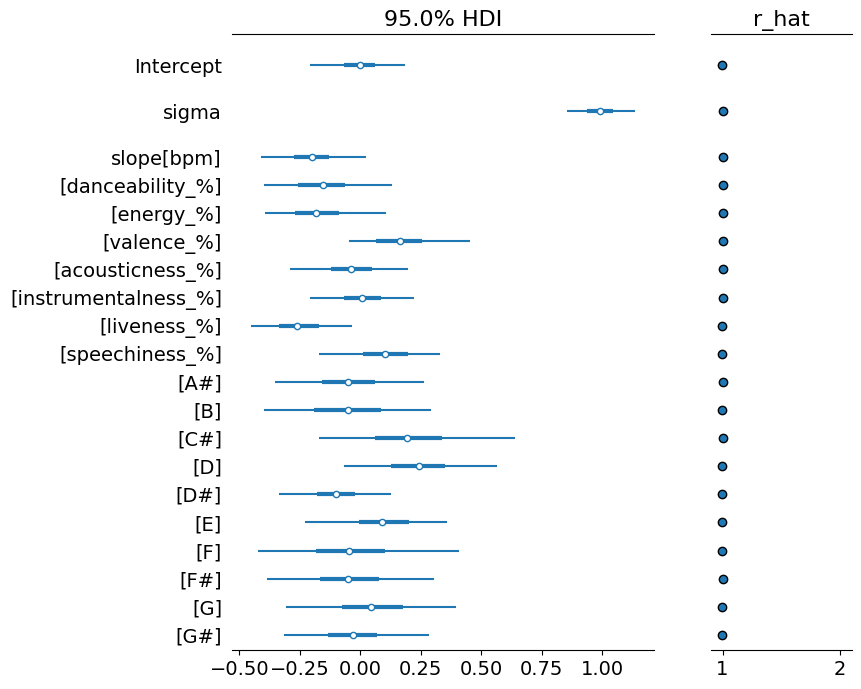

In [295]:
az.plot_forest(sample,var_names=['Intercept','sigma','slope'],combined=True,hdi_prob=.95,r_hat=True)

In [296]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_key.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_key.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_key.columns)
posterior_df["Intercept"] = intercept_rescaled

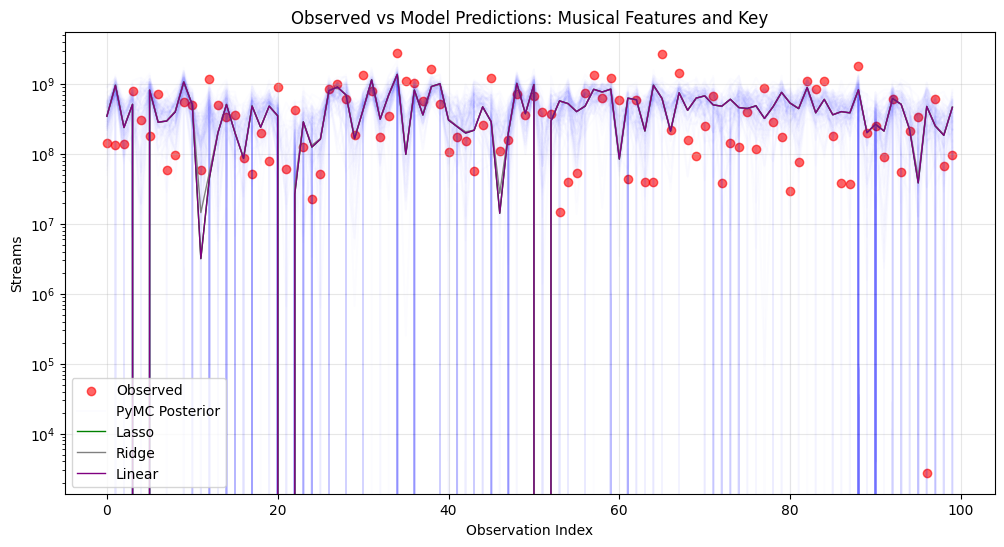

In [299]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_key.values, row[X_key.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_key)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


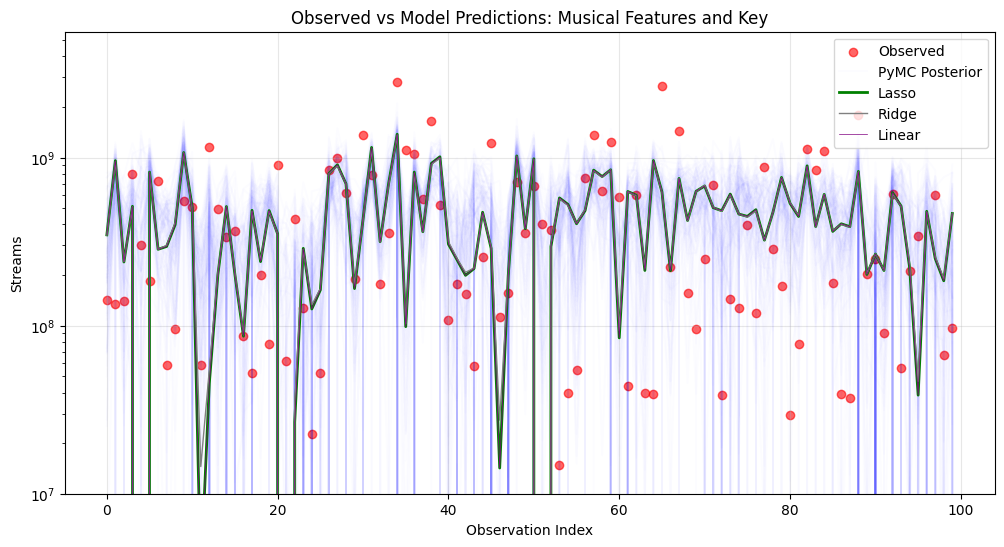

In [300]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_key.values, row[X_key.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_key)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Key")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [301]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

y = df['streams']

In [302]:
X_key = pd.concat([
    df[musical_features],
    pd.get_dummies(df['key'], drop_first=True)
], axis=1)

In [303]:
X_train, X_test, y_train, y_test = train_test_split(
    X_key, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [304]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

results_lin_key = pd.DataFrame({
    'feature': X_train.columns,
    'lin_coef': lin_model.coef_,
})

results_lin_key['lin_intercept'] = lin_model.intercept_
results_lin_key['lin_r2'] = r2_score(y_test, y_pred_lin)
results_lin_key['lin_mse'] = mean_squared_error(y_test, y_pred_lin)



In [305]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

results_ridge_key = pd.DataFrame({
    'feature': X_train.columns,
    'ridge_coef': ridge_model.coef_,
})

results_ridge_key['ridge_intercept'] = ridge_model.intercept_
results_ridge_key['ridge_r2'] = r2_score(y_test, y_pred_ridge)
results_ridge_key['ridge_mse'] = mean_squared_error(y_test, y_pred_ridge)


In [306]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

results_lasso_key = pd.DataFrame({
    'feature': X_train.columns,
    'lasso_coef': lasso_model.coef_,
})

results_lasso_key['lasso_intercept'] = lasso_model.intercept_
results_lasso_key['lasso_r2'] = r2_score(y_test, y_pred_lasso)
results_lasso_key['lasso_mse'] = mean_squared_error(y_test, y_pred_lasso)



In [307]:
X_scaled = (X_key - X_key.mean()) / X_key.std()
y_scaled = (y - y.mean()) / y.std()

with pm.Model(coords={"predictors": X_key.columns.values}) as bayes_key_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(draws=300, tune=300, chains=2, cores=2, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 173 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [308]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 -0.000  0.035  -0.067    0.066      0.001    0.002   
slope[bpm]                 0.021  0.038  -0.051    0.089      0.001    0.001   
slope[danceability_%]     -0.057  0.047  -0.142    0.027      0.002    0.002   
slope[energy_%]           -0.066  0.051  -0.156    0.035      0.002    0.002   
slope[valence_%]          -0.032  0.047  -0.115    0.061      0.002    0.002   
slope[acousticness_%]     -0.030  0.047  -0.123    0.053      0.003    0.002   
slope[instrumentalness_%] -0.014  0.034  -0.082    0.040      0.001    0.001   
slope[liveness_%]         -0.039  0.040  -0.115    0.034      0.001    0.002   
slope[speechiness_%]      -0.089  0.037  -0.150   -0.008      0.001    0.002   
slope[A#]                  0.083  0.047  -0.005    0.167      0.003    0.001   
slope[B]                   0.071  0.052  -0.037    0.158      0.003    0.002   
slope[C#]                  0.116  0.056   0.005    0.211      0.004    0.002   
slope[D]                   0.072  0.051  -0.008    0.179      0.003    0.002   
slope[D#]                  0.053  0.044  -0.032    0.124      0.002    0.002   
slope[E]                   0.058  0.049  -0.038    0.142      0.003    0.002   
slope[F]                   0.066  0.052  -0.030    0.159      0.003    0.002   
slope[F#]                  0.041  0.052  -0.056    0.137      0.003    0.002   
slope[G]                   0.011  0.052  -0.083    0.109      0.003    0.002   
slope[G#]                  0.050  0.051  -0.045    0.144      0.003    0.002   
sigma                      0.999  0.025   0.955    1.046      0.001    0.001   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1072.0     493.0   1.01  
slope[bpm]                    836.0     461.0   1.00  
slope[danceability_%]         565.0     487.0   1.00  
slope[energy_%]               643.0     467.0   1.00  
slope[valence_%]              501.0     449.0   1.01  
slope[acousticness_%]         306.0     510.0   1.01  
slope[instrumentalness_%]    1128.0     470.0   1.00  
slope[liveness_%]            1323.0     493.0   1.00  
slope[speechiness_%]          839.0     351.0   1.01  
slope[A#]                     258.0     434.0   1.01  
slope[B]                      277.0     460.0   1.01  
slope[C#]                     230.0     241.0   1.01  
slope[D]                      269.0     368.0   1.01  
slope[D#]                     400.0     401.0   1.00  
slope[E]                      281.0     495.0   1.01  
slope[F]                      236.0     307.0   1.01  
slope[F#]                     213.0     303.0   1.01  
slope[G]                      222.0     309.0   1.01  
slope[G#]                     255.0     506.0   1.01  
sigma                        1301.0     378.0   1.01

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

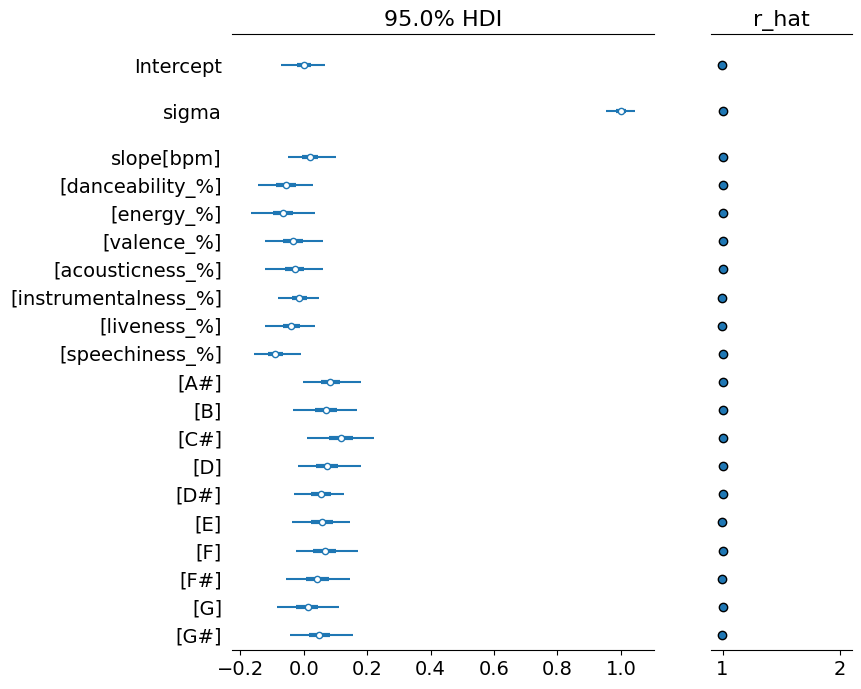

In [309]:
az.plot_forest(sample,var_names=['Intercept','sigma','slope'],combined=True,hdi_prob=.95,r_hat=True)

In [310]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_key.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_key.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_key.columns)
posterior_df["Intercept"] = intercept_rescaled

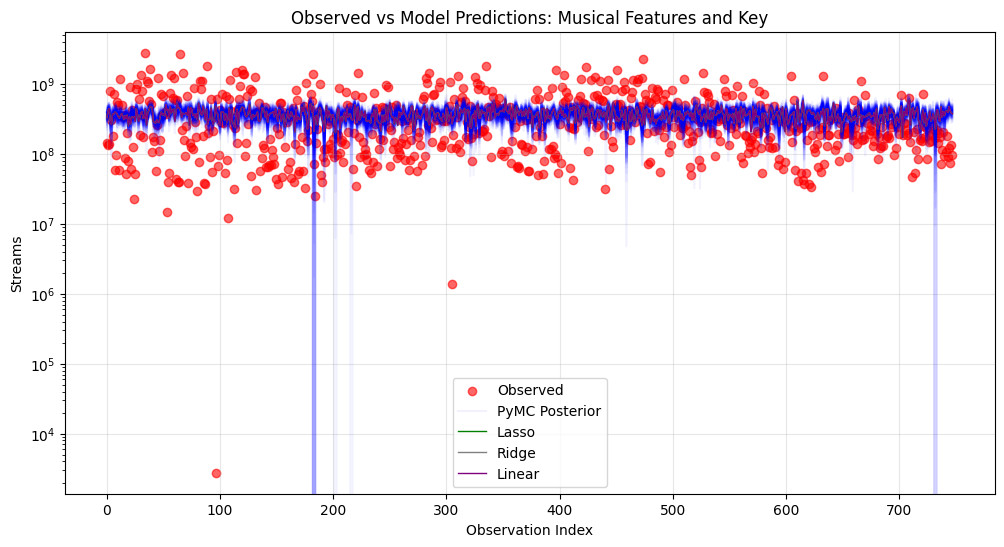

In [311]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_key.values, row[X_key.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_key)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


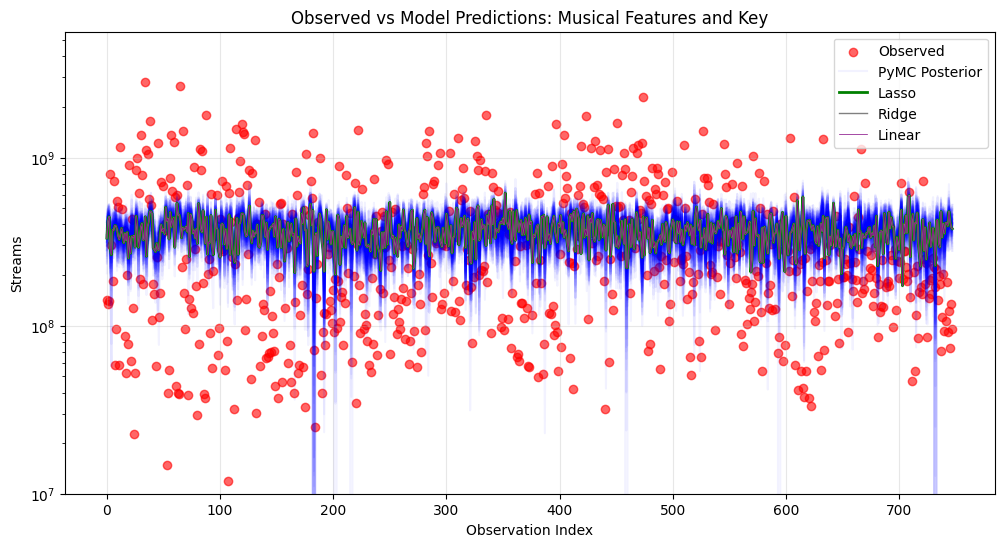

In [312]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_key.values, row[X_key.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.05, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_key)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions: Musical Features and Key")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in a reduced dataset of size 100 and if days of the week and key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [313]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

df_reduced=df[0:100]

In [314]:
categorical_features = ['day_of_week', 'key']

X_cat = pd.get_dummies(
    df_reduced[categorical_features],
    drop_first=True
)


In [315]:
X_multi = pd.concat(
    [df_reduced[musical_features], X_cat],
    axis=1
)

y = df_reduced['streams']


In [316]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [317]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)


c:\Users\Sofia Luis\Documents\ECE 4502\Probabilistic-Machine-Learning-Football-Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.625e+16, tolerance: 2.451e+15
  model = cd_fast.enet_coordinate_descent(


In [318]:
results_multivar = pd.DataFrame({
    'model': ['Linear', 'Ridge', 'Lasso'],
    'r2': [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso)
    ],
    'mse': [
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso)
    ]
})

results_multivar


model        r2           mse
0  Linear -1.509724  4.039686e+17
1   Ridge -1.449740  3.943136e+17
2   Lasso -1.554899  4.112400e+17

In [319]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()


In [320]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_model:
    intercept = pm.Normal("Intercept", 0, 10)
    slope = pm.Normal("slope", 0, 5, dims="predictors")
    sigma = pm.HalfNormal("sigma", 10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        cores=2,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 44 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


A single multivariate regression model was constructed using intrinsic musical features alongside day-of-week and key indicators to assess whether temporal and tonal attributes add predictive power beyond audio characteristics alone.

In [321]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     0.003  0.089  -0.160    0.161      0.003   
slope[bpm]                   -0.260  0.110  -0.452   -0.058      0.004   
slope[danceability_%]        -0.145  0.130  -0.355    0.118      0.005   
slope[energy_%]              -0.105  0.143  -0.354    0.182      0.006   
slope[valence_%]              0.137  0.119  -0.078    0.368      0.004   
slope[acousticness_%]        -0.030  0.124  -0.259    0.193      0.005   
slope[instrumentalness_%]     0.013  0.110  -0.178    0.226      0.005   
slope[liveness_%]            -0.218  0.103  -0.402   -0.026      0.004   
slope[speechiness_%]          0.067  0.123  -0.149    0.291      0.005   
slope[day_of_week_Monday]    -0.025  0.099  -0.218    0.159      0.003   
slope[day_of_week_Saturday]   0.068  0.139  -0.173    0.340      0.005   
slope[day_of_week_Sunday]     0.164  0.121  -0.036    0.405      0.005   
slope[day_of_week_Thursday]   0.019  0.110  -0.182    0.221      0.004   
slope[day_of_week_Tuesday]    0.396  0.113   0.179    0.595      0.004   
slope[day_of_week_Wednesday]  0.092  0.112  -0.105    0.309      0.004   
slope[key_A#]                -0.086  0.138  -0.341    0.176      0.007   
slope[key_B]                 -0.064  0.152  -0.334    0.225      0.008   
slope[key_C#]                 0.209  0.168  -0.129    0.506      0.009   
slope[key_D]                  0.187  0.150  -0.121    0.450      0.008   
slope[key_D#]                -0.110  0.148  -0.370    0.163      0.006   
slope[key_E]                  0.055  0.146  -0.196    0.329      0.007   
slope[key_F]                 -0.039  0.178  -0.367    0.286      0.009   
slope[key_F#]                -0.143  0.150  -0.442    0.113      0.008   
slope[key_G]                  0.026  0.156  -0.249    0.331      0.008   
slope[key_G#]                -0.018  0.128  -0.262    0.215      0.006   
sigma                         0.928  0.074   0.793    1.061      0.004   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.004     924.0     465.0   1.00  
slope[bpm]                      0.005     682.0     497.0   1.00  
slope[danceability_%]           0.005     827.0     543.0   1.01  
slope[energy_%]                 0.006     499.0     356.0   1.00  
slope[valence_%]                0.004     725.0     373.0   1.00  
slope[acousticness_%]           0.005     678.0     548.0   1.00  
slope[instrumentalness_%]       0.005     548.0     392.0   1.00  
slope[liveness_%]               0.004     871.0     496.0   1.00  
slope[speechiness_%]            0.004     622.0     486.0   1.00  
slope[day_of_week_Monday]       0.004     812.0     442.0   1.00  
slope[day_of_week_Saturday]     0.005     695.0     390.0   1.00  
slope[day_of_week_Sunday]       0.004     720.0     586.0   1.00  
slope[day_of_week_Thursday]     0.004     735.0     526.0   1.00  
slope[day_of_week_Tuesday]      0.005     648.0     419.0   1.01  
slope[day_of_week_Wednesday]    0.008     899.0     334.0   1.05  
slope[key_A#]                   0.005     404.0     515.0   1.00  
slope[key_B]                    0.006     371.0     392.0   1.00  
slope[key_C#]                   0.006     313.0     384.0   1.00  
slope[key_D]                    0.006     369.0     436.0   1.00  
slope[key_D#]                   0.005     637.0     515.0   1.00  
slope[key_E]                    0.006     477.0     431.0   1.00  
slope[key_F]                    0.007     344.0     346.0   1.00  
slope[key_F#]                   0.005     325.0     454.0   1.00  
slope[key_G]                    0.006     366.0     422.0   1.00  
slope[key_G#]                   0.005     406.0     401.0   1.00  
sigma                           0.003     413.0     352.0   1.01

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

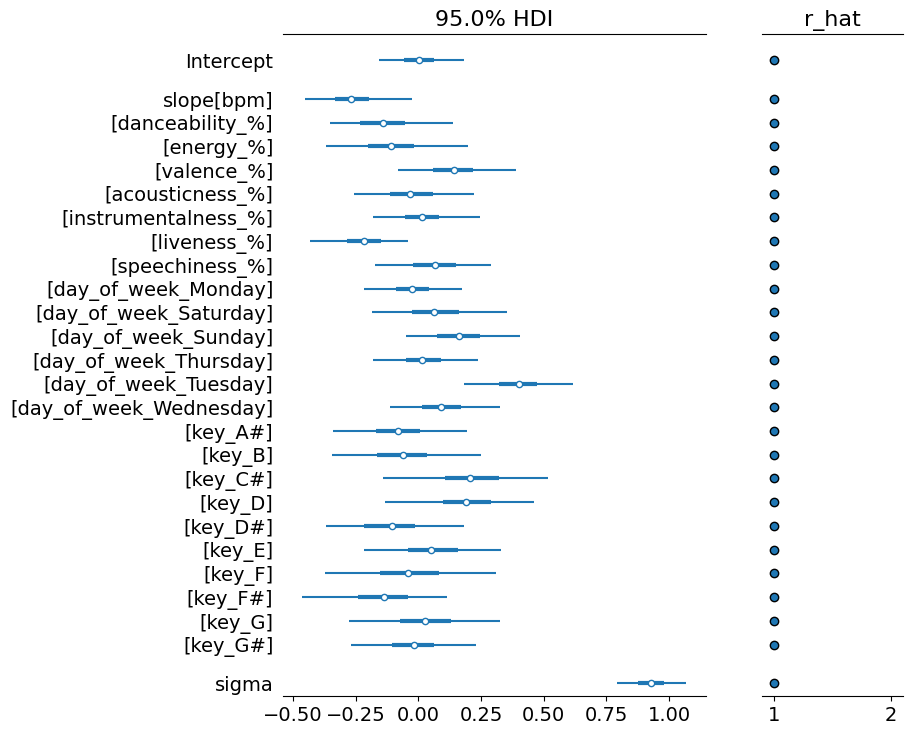

In [322]:
az.plot_forest(sample,var_names=["Intercept",'slope','sigma'],combined=True,hdi_prob=0.95,r_hat=True)

In [323]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

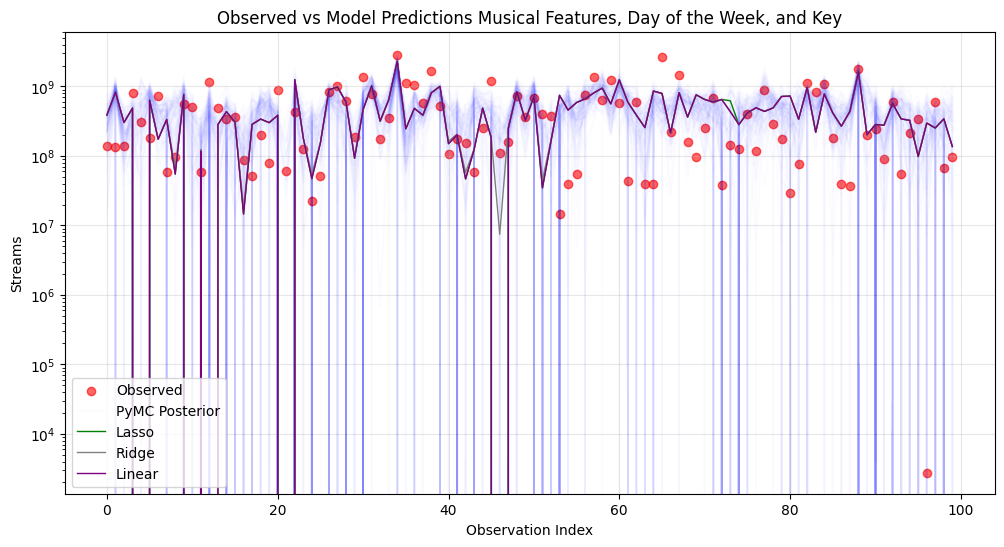

In [326]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)#scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


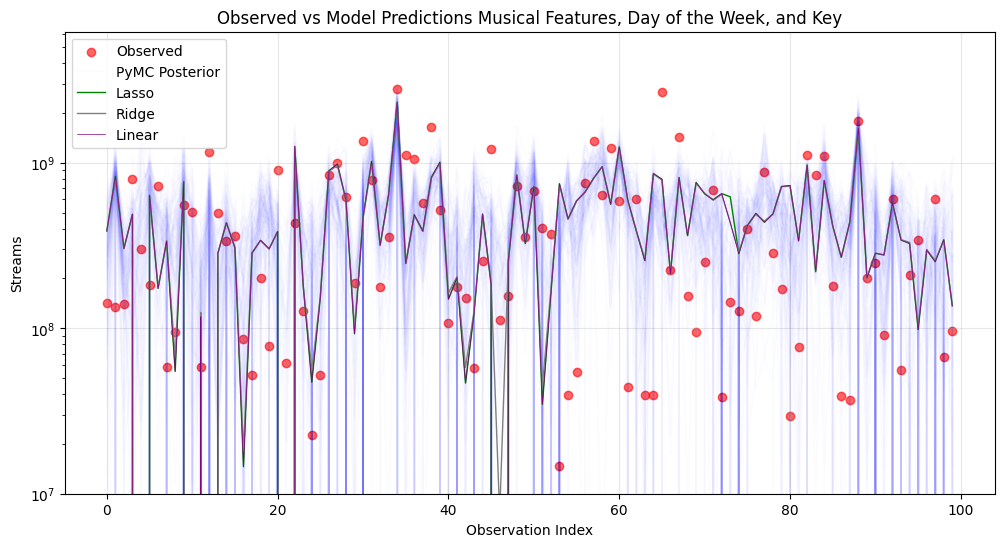

In [328]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if streams can be predicted based on musical features in the dataset and if days of the week and key of the song makes an impact using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [329]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]


In [330]:
categorical_features = ['day_of_week', 'key']

X_cat = pd.get_dummies(
    df[categorical_features],
    drop_first=True
)


In [331]:
X_multi = pd.concat(
    [df[musical_features], X_cat],
    axis=1
)

y = df['streams']


In [332]:
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [333]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)


In [334]:
results_multivar = pd.DataFrame({
    'model': ['Linear', 'Ridge', 'Lasso'],
    'r2': [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso)
    ],
    'mse': [
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso)
    ]
})

results_multivar


model        r2           mse
0  Linear -0.058431  1.772437e+17
1   Ridge -0.058307  1.772230e+17
2   Lasso -0.058431  1.772437e+17

In [335]:
X_scaled = (X_multi - X_multi.mean()) / X_multi.std()
y_scaled = (y - y.mean()) / y.std()


In [336]:
with pm.Model(coords={"predictors": X_multi.columns.values}) as bayes_model:
    intercept = pm.Normal("Intercept", 0, 10)
    slope = pm.Normal("slope", 0, 5, dims="predictors")
    sigma = pm.HalfNormal("sigma", 10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        cores=2,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 177 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


A single multivariate regression model was constructed using intrinsic musical features alongside day-of-week and key indicators to assess whether temporal and tonal attributes add predictive power beyond audio characteristics alone.

In [337]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     0.000  0.034  -0.066    0.055      0.001   
slope[bpm]                    0.017  0.040  -0.062    0.090      0.001   
slope[danceability_%]        -0.059  0.045  -0.145    0.023      0.002   
slope[energy_%]              -0.069  0.049  -0.157    0.018      0.002   
slope[valence_%]             -0.037  0.043  -0.127    0.035      0.002   
slope[acousticness_%]        -0.030  0.048  -0.120    0.055      0.002   
slope[instrumentalness_%]    -0.015  0.038  -0.083    0.055      0.001   
slope[liveness_%]            -0.041  0.038  -0.110    0.033      0.001   
slope[speechiness_%]         -0.086  0.038  -0.157   -0.010      0.001   
slope[day_of_week_Monday]     0.008  0.038  -0.069    0.076      0.002   
slope[day_of_week_Saturday]  -0.014  0.037  -0.080    0.055      0.001   
slope[day_of_week_Sunday]     0.036  0.037  -0.030    0.099      0.001   
slope[day_of_week_Thursday]   0.045  0.039  -0.026    0.111      0.002   
slope[day_of_week_Tuesday]    0.049  0.041  -0.021    0.129      0.001   
slope[day_of_week_Wednesday]  0.064  0.038   0.003    0.146      0.001   
slope[key_A#]                 0.087  0.049   0.003    0.179      0.003   
slope[key_B]                  0.073  0.049  -0.022    0.157      0.003   
slope[key_C#]                 0.118  0.053   0.027    0.219      0.004   
slope[key_D]                  0.074  0.048  -0.022    0.160      0.003   
slope[key_D#]                 0.059  0.042  -0.019    0.134      0.002   
slope[key_E]                  0.065  0.046  -0.021    0.150      0.003   
slope[key_F]                  0.068  0.050  -0.033    0.155      0.004   
slope[key_F#]                 0.039  0.049  -0.051    0.130      0.003   
slope[key_G]                  0.016  0.052  -0.079    0.118      0.003   
slope[key_G#]                 0.053  0.048  -0.035    0.146      0.003   
sigma                         0.998  0.027   0.946    1.042      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.001     788.0     440.0   1.00  
slope[bpm]                      0.002    1049.0     261.0   1.00  
slope[danceability_%]           0.001     503.0     548.0   1.00  
slope[energy_%]                 0.002     533.0     515.0   1.00  
slope[valence_%]                0.001     544.0     536.0   1.00  
slope[acousticness_%]           0.003     657.0     477.0   1.01  
slope[instrumentalness_%]       0.002     798.0     389.0   1.01  
slope[liveness_%]               0.002     797.0     469.0   1.00  
slope[speechiness_%]            0.002     735.0     541.0   1.00  
slope[day_of_week_Monday]       0.001     465.0     493.0   1.00  
slope[day_of_week_Saturday]     0.001     777.0     473.0   1.01  
slope[day_of_week_Sunday]       0.002     946.0     486.0   1.00  
slope[day_of_week_Thursday]     0.001     481.0     481.0   1.00  
slope[day_of_week_Tuesday]      0.002    1205.0     305.0   1.02  
slope[day_of_week_Wednesday]    0.001     881.0     603.0   1.00  
slope[key_A#]                   0.002     268.0     391.0   1.01  
slope[key_B]                    0.002     242.0     327.0   1.01  
slope[key_C#]                   0.002     207.0     333.0   1.02  
slope[key_D]                    0.002     256.0     378.0   1.01  
slope[key_D#]                   0.002     312.0     418.0   1.01  
slope[key_E]                    0.002     234.0     383.0   1.02  
slope[key_F]                    0.002     180.0     358.0   1.02  
slope[key_F#]                   0.002     237.0     372.0   1.02  
slope[key_G]                    0.002     232.0     420.0   1.01  
slope[key_G#]                   0.002     235.0     413.0   1.01  
sigma                           0.001     882.0     516.0   1.00

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

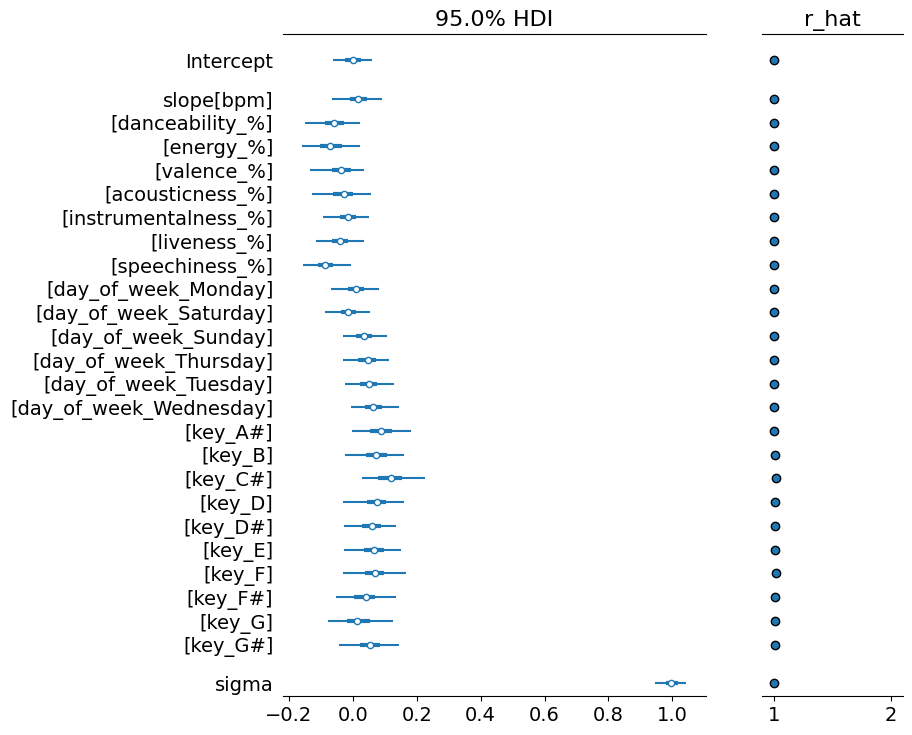

In [338]:
az.plot_forest(sample,var_names=["Intercept",'slope','sigma'],combined=True,hdi_prob=0.95,r_hat=True)

In [339]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_multi.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_multi.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_multi.columns)
posterior_df["Intercept"] = intercept_rescaled

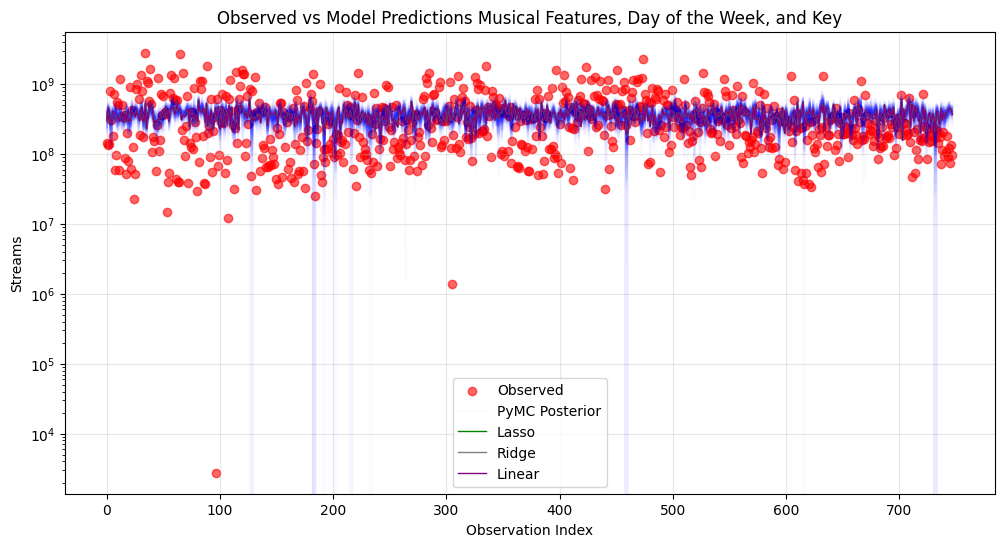

In [343]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.02, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)#scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


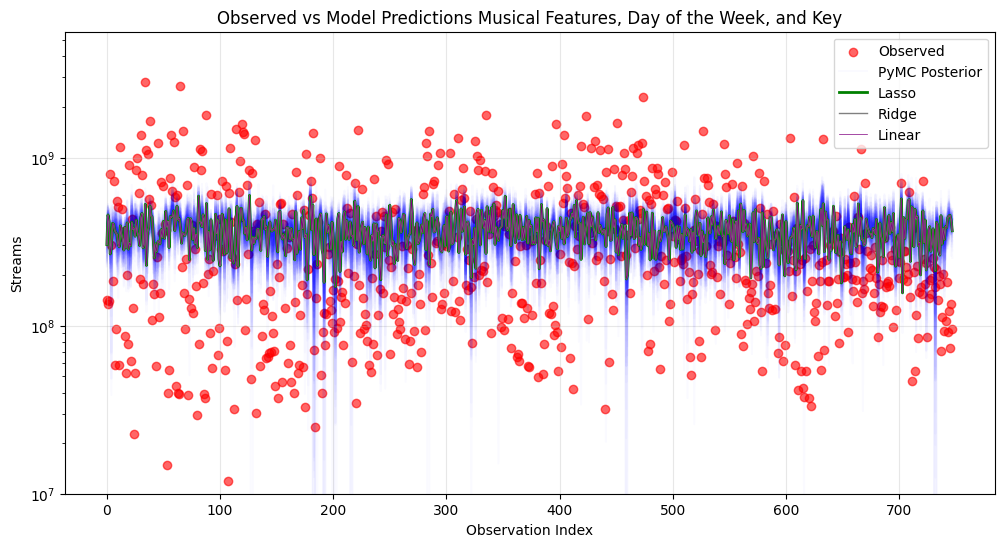

In [344]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_multi.values, row[X_multi.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.02, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_multi)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Multivariate Regression

This portion of the analysis sees if the number of artists impacts the quality of prediction of streams based on musical features in a reduced dataset of size 100 (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [365]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

df_reduced=df[0:100]

X_music = df_reduced[musical_features]

In [366]:
X_music_artist = df_reduced[musical_features + ['artist_count']]

In [367]:
y = df_reduced['streams']

In [368]:
X_train, X_test, y_train, y_test = train_test_split(
    X_music_artist, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [369]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

lin_results = {
    'model': 'Linear',
    'r2': r2_score(y_test, y_pred_lin),
    'mse': mean_squared_error(y_test, y_pred_lin)
}

In [370]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_results = {
    'model': 'Ridge',
    'r2': r2_score(y_test, y_pred_ridge),
    'mse': mean_squared_error(y_test, y_pred_ridge)
}

In [371]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

lasso_results = {
    'model': 'Lasso',
    'r2': r2_score(y_test, y_pred_lasso),
    'mse': mean_squared_error(y_test, y_pred_lasso)
}

In [372]:
X_scaled = (X_music_artist - X_music_artist.mean()) / X_music_artist.std()
y_scaled = (y - y.mean()) / y.std()


In [353]:
with pm.Model(coords={"predictors": X_music_artist.columns.values}) as bayes_artist_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        cores=2,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [354]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 -0.000  0.093  -0.172    0.173      0.003    0.004   
slope[bpm]                -0.181  0.110  -0.396    0.016      0.004    0.005   
slope[danceability_%]     -0.131  0.131  -0.347    0.132      0.005    0.005   
slope[energy_%]           -0.196  0.134  -0.453    0.038      0.004    0.005   
slope[valence_%]           0.085  0.124  -0.134    0.319      0.004    0.005   
slope[acousticness_%]     -0.104  0.119  -0.324    0.126      0.004    0.005   
slope[instrumentalness_%]  0.014  0.097  -0.191    0.175      0.003    0.003   
slope[liveness_%]         -0.228  0.105  -0.430   -0.034      0.004    0.004   
slope[speechiness_%]       0.086  0.127  -0.137    0.331      0.004    0.005   
slope[artist_count]        0.086  0.104  -0.085    0.293      0.003    0.004   
sigma                      1.001  0.083   0.868    1.169      0.003    0.004   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1046.0     509.0   1.01  
slope[bpm]                    861.0     466.0   1.01  
slope[danceability_%]         635.0     404.0   1.01  
slope[energy_%]               912.0     469.0   1.00  
slope[valence_%]              913.0     522.0   1.00  
slope[acousticness_%]         872.0     543.0   1.00  
slope[instrumentalness_%]    1127.0     545.0   1.00  
slope[liveness_%]             877.0     416.0   1.00  
slope[speechiness_%]          830.0     519.0   1.00  
slope[artist_count]           987.0     518.0   1.00  
sigma                         636.0     385.0   1.00

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

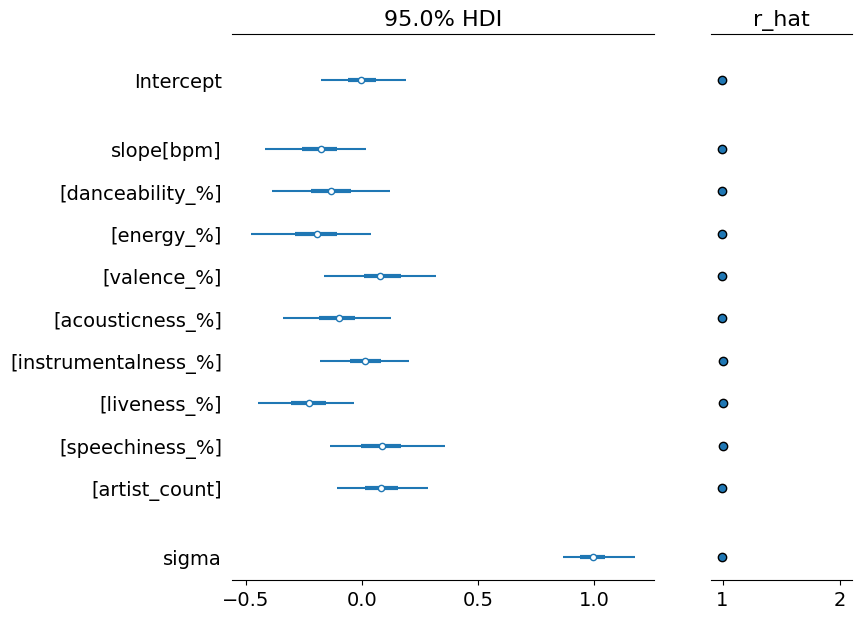

In [355]:
az.plot_forest(sample,var_names=['Intercept','slope','sigma'],combined=True,hdi_prob=.95,r_hat=True)

In [356]:
"""
slope_samples = sample.posterior["slope"].values
intercept_samples = sample.posterior["Intercept"].values

slope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])
intercept_flat = intercept_samples.flatten()

slope_rescaled = slope_flat * y.std() / X_music_artist.std().values
intercept_rescaled = (
    intercept_flat * y.std()
    + y.mean()
    - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)
)

bayes_coef_df = pd.DataFrame({
    'feature': X_music_artist.columns,
    'bayes_coef_mean': slope_rescaled.mean(axis=0),
    'bayes_coef_sd': slope_rescaled.std(axis=0)
})

bayes_coef_df
"""

'\nslope_samples = sample.posterior["slope"].values\nintercept_samples = sample.posterior["Intercept"].values\n\nslope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])\nintercept_flat = intercept_samples.flatten()\n\nslope_rescaled = slope_flat * y.std() / X_music_artist.std().values\nintercept_rescaled = (\n    intercept_flat * y.std()\n    + y.mean()\n    - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)\n)\n\nbayes_coef_df = pd.DataFrame({\n    \'feature\': X_music_artist.columns,\n    \'bayes_coef_mean\': slope_rescaled.mean(axis=0),\n    \'bayes_coef_sd\': slope_rescaled.std(axis=0)\n})\n\nbayes_coef_df\n'

In [373]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_music_artist.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_music_artist.columns)
posterior_df["Intercept"] = intercept_rescaled

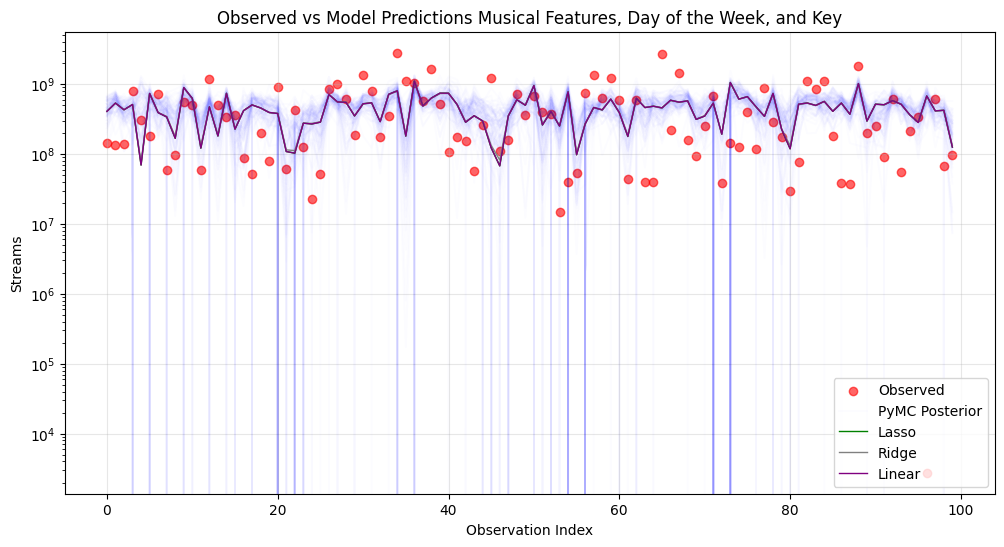

In [374]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_music_artist.values, row[X_music_artist.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_music_artist)#scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


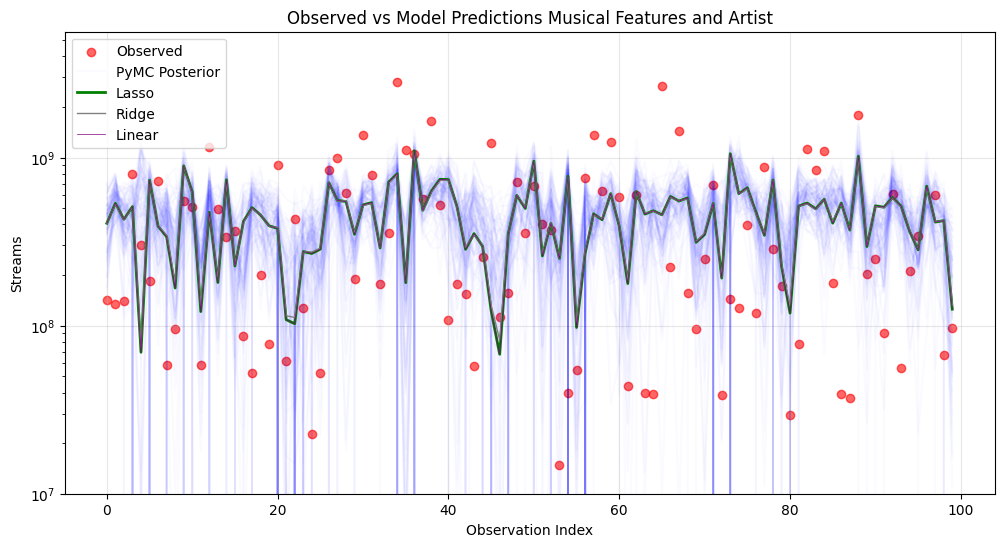

In [376]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_music_artist.values, row[X_music_artist.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.02, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_music_artist)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features and Artist")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [377]:
# Train identical model without artist_count
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_music, y, test_size=0.2, random_state=42
)

X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

lin_base = LinearRegression().fit(X_train_m, y_train_m)
y_pred_base = lin_base.predict(X_test_m)

print("Musical only R²:", r2_score(y_test_m, y_pred_base))
print("Musical + artist_count R²:", lin_results['r2'])


Musical only R²: -0.1862842808276164
Musical + artist_count R²: -0.37331140824815723


# Multivariate Regression

This portion of the analysis sees if the number of artists impacts the quality of prediction of streams based on musical features in the dataset (without categorical variables that are one-hot encoded) using linear regression, ridge regression, lasso regression, and bayesian linear regression.

In [395]:
musical_features = [
    'bpm',
    'danceability_%',
    'energy_%',
    'valence_%',
    'acousticness_%',
    'instrumentalness_%',
    'liveness_%',
    'speechiness_%'
]

X_music = df[musical_features]

In [396]:
X_music_artist = df[musical_features + ['artist_count']]

In [397]:
y = df['streams']

In [398]:
X_train, X_test, y_train, y_test = train_test_split(
    X_music_artist, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [399]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)
y_pred_lin = lin_model.predict(X_test_scaled)

lin_results = {
    'model': 'Linear',
    'r2': r2_score(y_test, y_pred_lin),
    'mse': mean_squared_error(y_test, y_pred_lin)
}

In [400]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_results = {
    'model': 'Ridge',
    'r2': r2_score(y_test, y_pred_ridge),
    'mse': mean_squared_error(y_test, y_pred_ridge)
}

In [401]:
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)

lasso_results = {
    'model': 'Lasso',
    'r2': r2_score(y_test, y_pred_lasso),
    'mse': mean_squared_error(y_test, y_pred_lasso)
}

In [402]:
X_scaled = (X_music_artist - X_music_artist.mean()) / X_music_artist.std()
y_scaled = (y - y.mean()) / y.std()


In [386]:
with pm.Model(coords={"predictors": X_music_artist.columns.values}) as bayes_artist_model:
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=5, dims="predictors")
    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = intercept + pm.math.dot(X_scaled.values, slope)
    likelihood = pm.Normal("streams", mu=mu, sigma=sigma, observed=y_scaled)

    sample = pm.sample(
        draws=300,
        tune=300,
        chains=2,
        cores=2,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Output()

Sampling 2 chains for 300 tune and 300 draw iterations (600 + 600 draws total) took 160 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [387]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  0.000  0.035  -0.074    0.059      0.001    0.002   
slope[bpm]                 0.012  0.036  -0.057    0.074      0.001    0.002   
slope[danceability_%]     -0.042  0.042  -0.121    0.034      0.001    0.001   
slope[energy_%]           -0.051  0.048  -0.135    0.039      0.002    0.002   
slope[valence_%]          -0.036  0.044  -0.118    0.047      0.002    0.002   
slope[acousticness_%]     -0.031  0.043  -0.116    0.047      0.002    0.002   
slope[instrumentalness_%] -0.019  0.034  -0.078    0.044      0.001    0.002   
slope[liveness_%]         -0.037  0.037  -0.104    0.027      0.001    0.001   
slope[speechiness_%]      -0.074  0.036  -0.148   -0.012      0.001    0.002   
slope[artist_count]       -0.063  0.038  -0.131    0.006      0.001    0.002   
sigma                      0.996  0.026   0.951    1.049      0.001    0.001   

                           ess_bulk  ess_tail  r_hat  
Intercept                    1009.0     419.0   1.00  
slope[bpm]                    863.0     512.0   1.03  
slope[danceability_%]         865.0     531.0   1.00  
slope[energy_%]               731.0     510.0   1.00  
slope[valence_%]              762.0     471.0   1.00  
slope[acousticness_%]         780.0     549.0   1.00  
slope[instrumentalness_%]     976.0     378.0   1.01  
slope[liveness_%]            1191.0     427.0   1.01  
slope[speechiness_%]         1152.0     461.0   1.00  
slope[artist_count]          1099.0     401.0   1.01  
sigma                         851.0     501.0   1.00

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

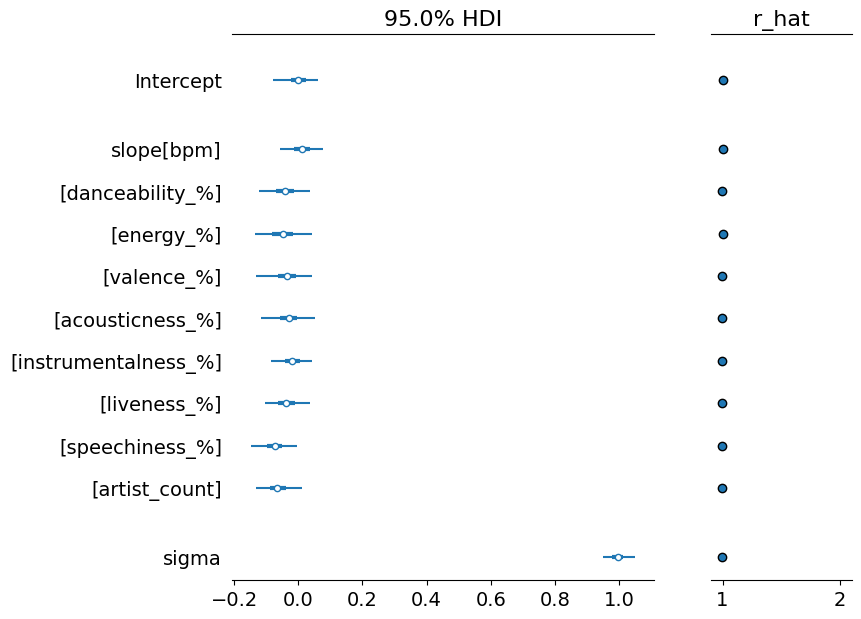

In [388]:
az.plot_forest(sample,var_names=['Intercept','slope','sigma'],combined=True,hdi_prob=.95,r_hat=True)

In [389]:
"""
slope_samples = sample.posterior["slope"].values
intercept_samples = sample.posterior["Intercept"].values

slope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])
intercept_flat = intercept_samples.flatten()

slope_rescaled = slope_flat * y.std() / X_music_artist.std().values
intercept_rescaled = (
    intercept_flat * y.std()
    + y.mean()
    - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)
)

bayes_coef_df = pd.DataFrame({
    'feature': X_music_artist.columns,
    'bayes_coef_mean': slope_rescaled.mean(axis=0),
    'bayes_coef_sd': slope_rescaled.std(axis=0)
})

bayes_coef_df
"""

'\nslope_samples = sample.posterior["slope"].values\nintercept_samples = sample.posterior["Intercept"].values\n\nslope_flat = slope_samples.reshape(-1, slope_samples.shape[-1])\nintercept_flat = intercept_samples.flatten()\n\nslope_rescaled = slope_flat * y.std() / X_music_artist.std().values\nintercept_rescaled = (\n    intercept_flat * y.std()\n    + y.mean()\n    - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)\n)\n\nbayes_coef_df = pd.DataFrame({\n    \'feature\': X_music_artist.columns,\n    \'bayes_coef_mean\': slope_rescaled.mean(axis=0),\n    \'bayes_coef_sd\': slope_rescaled.std(axis=0)\n})\n\nbayes_coef_df\n'

In [390]:
#extract slope & intercept samples
slope_samples = sample.posterior["slope"].values  # shape: (chains, draws, predictors)
intercept_samples = sample.posterior["Intercept"].values  # shape: (chains, draws)

#flatten
n_chains, n_draws, n_pred = slope_samples.shape
slope_flat = slope_samples.reshape(-1, n_pred)
intercept_flat = intercept_samples.flatten()

#rescale slopes back to original X and Y units
slope_rescaled = slope_flat * y.std() / X_music_artist.std().values

#rescale intercepts
intercept_rescaled = intercept_flat * y.std() + y.mean() - (slope_rescaled * X_music_artist.mean().values).sum(axis=1)

#combine into a dataframe
posterior_df = pd.DataFrame(slope_rescaled, columns=X_music_artist.columns)
posterior_df["Intercept"] = intercept_rescaled

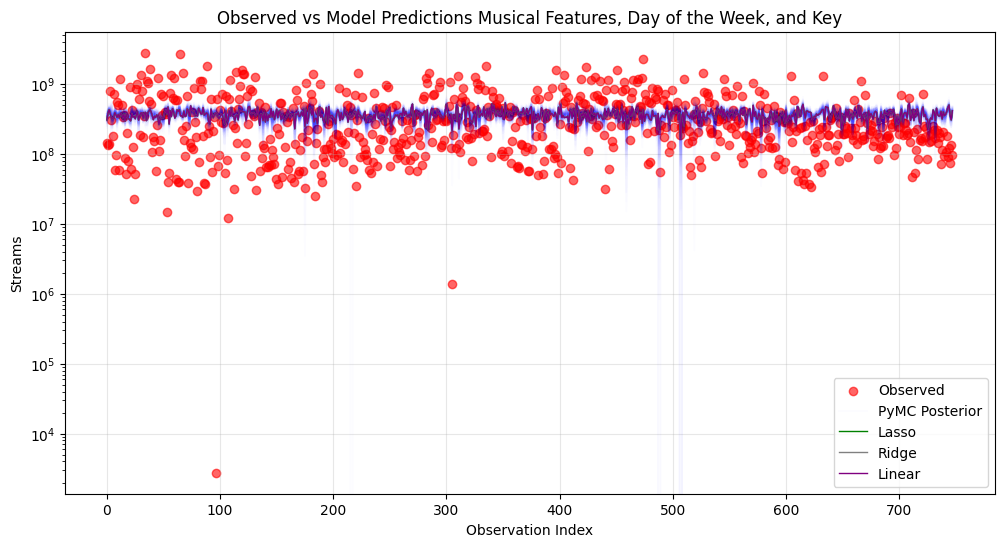

In [403]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_music_artist.values, row[X_music_artist.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.01, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_music_artist)#scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=1, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=1, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features, Day of the Week, and Key")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


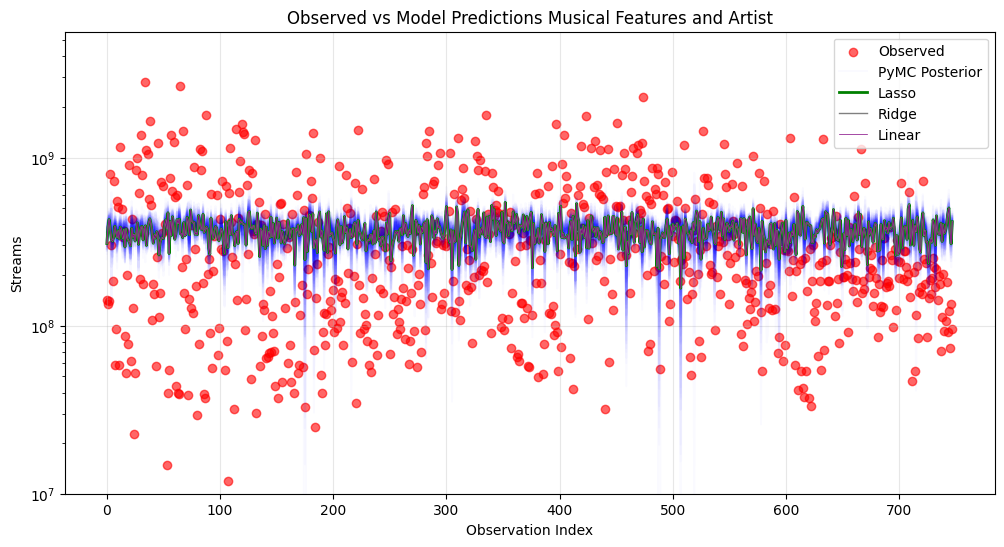

In [404]:
plt.figure(figsize=(12,6))

#observed scatter plot from data
plt.scatter(np.arange(len(y)), y.values, color="red", alpha=0.6, label="Observed")

#plot 100 random posterior draws
n_draws_plot = 100
draw_indices = np.random.choice(len(posterior_df), n_draws_plot, replace=False)

for idx in draw_indices:
    row = posterior_df.iloc[idx]
    y_pred = row["Intercept"] + np.dot(X_music_artist.values, row[X_music_artist.columns].values)
    plt.plot(np.arange(len(y)), y_pred, color="blue", alpha=0.02, label="PyMC Posterior" if idx == draw_indices[0] else "")

X_scaled_all = scaler.transform(X_music_artist)  #scale rows the same way
y_lasso_pred = lasso_model.intercept_ + np.dot(X_scaled_all, lasso_model.coef_)
plt.plot(np.arange(len(y)), y_lasso_pred, color="green", lw=2, label="Lasso")

y_ridge_pred = ridge_model.intercept_ + np.dot(X_scaled_all, ridge_model.coef_)
plt.plot(np.arange(len(y)), y_ridge_pred, color="gray", lw=1, label="Ridge")

y_lin_pred = lin_model.intercept_ + np.dot(X_scaled_all, lin_model.coef_)
plt.plot(np.arange(len(y)), y_lin_pred, color="purple", lw=0.5, label="Linear")

plt.xlabel("Observation Index")
plt.ylabel("Streams")
plt.title("Observed vs Model Predictions Musical Features and Artist")
plt.yscale("log")
plt.ylim(bottom=1e7)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [405]:
# Train identical model without artist_count
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_music, y, test_size=0.2, random_state=42
)

X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

lin_base = LinearRegression().fit(X_train_m, y_train_m)
y_pred_base = lin_base.predict(X_test_m)

print("Musical only R²:", r2_score(y_test_m, y_pred_base))
print("Musical + artist_count R²:", lin_results['r2'])


Musical only R²: -0.02003833940489841
Musical + artist_count R²: -0.016293388536346987


# Covariance Analysis

Do day of week and musical key have linear relationships with streams, and do they introduce multicollinearity in a reduced dataset of size 100?

In [406]:
df_reduced=df[0:100]

X_numeric = df_reduced.drop(columns=[
    'track_name','artist(s)_name','streams',
    'day_of_week','key','mode','Full Key'
])

y = df_reduced['streams']

In [407]:
categorical_features = ['day_of_week', 'key']

X_cat = pd.get_dummies(
    df_reduced[categorical_features],
    drop_first=True
)


In [408]:
X_full = pd.concat([X_numeric, X_cat], axis=1)

# Add streams for analysis
df_corr = pd.concat([X_full, y], axis=1)


In [409]:
cov_matrix = df_corr.cov()
cov_matrix
corr_matrix = df_corr.corr()
corr_matrix

artist_count  released_year  released_month  \
artist_count               1.000000       0.126699       -0.009328   
released_year              0.126699       1.000000       -0.050094   
released_month            -0.009328      -0.050094        1.000000   
released_day              -0.089454       0.249110       -0.173698   
in_spotify_playlists       0.117729      -0.673019        0.098677   
in_spotify_charts          0.081057       0.025957        0.050795   
in_apple_playlists         0.110971      -0.243894        0.088617   
in_apple_charts            0.046184       0.089766       -0.093353   
in_deezer_playlists        0.159041      -0.482736        0.045020   
in_deezer_charts           0.201808       0.206775       -0.012270   
in_shazam_charts           0.042589       0.135115       -0.110119   
bpm                       -0.072063       0.026904       -0.099863   
danceability_%             0.225245       0.184376       -0.084390   
valence_%                  0.112573       0.118110       -0.222977   
energy_%                   0.082546       0.251925       -0.202103   
acousticness_%             0.069757       0.034852       -0.078864   
instrumentalness_%        -0.142294       0.073387        0.018836   
liveness_%                -0.040375       0.117315       -0.065740   
speechiness_%              0.117565      -0.125309        0.010924   
day_of_week_Monday        -0.056873       0.086299       -0.067011   
day_of_week_Saturday      -0.084925       0.049319       -0.126080   
day_of_week_Sunday        -0.056873      -0.465055       -0.163015   
day_of_week_Thursday       0.042307       0.132280        0.029572   
day_of_week_Tuesday       -0.012776      -0.212855        0.195229   
day_of_week_Wednesday      0.007655      -0.217196       -0.108386   
key_A#                     0.050076      -0.099871        0.207156   
key_B                      0.171690       0.140034       -0.119832   
key_C#                    -0.027317      -0.031233        0.060039   
key_D                      0.117012      -0.088593       -0.028270   
key_D#                    -0.008942       0.070102       -0.109025   
key_E                     -0.081703      -0.099871       -0.041100   
key_F                     -0.090146       0.029187        0.018619   
key_F#                     0.083456       0.068155       -0.068784   
key_G                     -0.047010      -0.010456       -0.043234   
key_G#                    -0.147593       0.072320        0.096820   
streams                    0.070916      -0.578898        0.199546   

                       released_day  in_spotify_playlists  in_spotify_charts  \
artist_count              -0.089454              0.117729           0.081057   
released_year              0.249110             -0.673019           0.025957   
released_month            -0.173698              0.098677           0.050795   
released_day               1.000000             -0.182014           0.034047   
in_spotify_playlists      -0.182014              1.000000           0.181397   
in_spotify_charts          0.034047              0.181397           1.000000   
in_apple_playlists        -0.095877              0.678002           0.298956   
in_apple_charts            0.039712              0.043051           0.495843   
in_deezer_playlists       -0.174771              0.899867           0.256544   
in_deezer_charts           0.118318              0.207881           0.475064   
in_shazam_charts           0.093051              0.017948           0.504225   
bpm                       -0.002204             -0.102702          -0.087222   
danceability_%             0.008847             -0.026119           0.113838   
valence_%                  0.201764             -0.062855           0.052400   
energy_%                   0.035339             -0.132528           0.177317   
acousticness_%             0.164957             -0.004020          -0.109945   
instrumentalness_%        -0.005298              0.004637           0.06

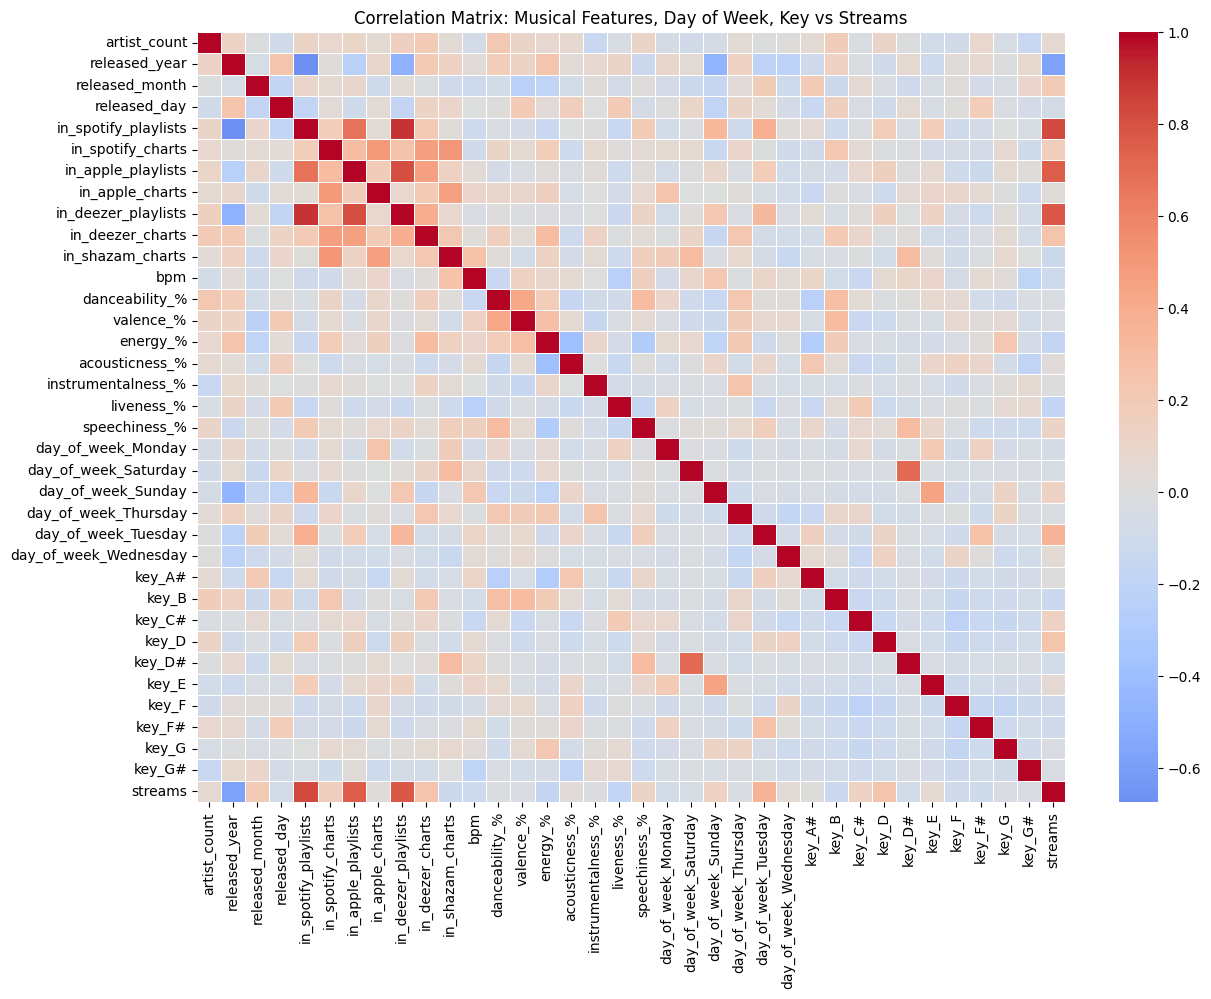

In [410]:
plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix: Musical Features, Day of Week, Key vs Streams")
plt.show()

In [411]:
corr_with_streams = corr_matrix['streams'].sort_values(ascending=False)
corr_with_streams

streams                  1.000000
in_spotify_playlists     0.829550
in_deezer_playlists      0.777652
in_apple_playlists       0.748916
day_of_week_Tuesday      0.363142
in_deezer_charts         0.253492
key_D                    0.246670
released_month           0.199546
in_spotify_charts        0.165634
key_C#                   0.147684
day_of_week_Sunday       0.134883
speechiness_%            0.124249
artist_count             0.070916
key_E                    0.053857
day_of_week_Wednesday    0.041736
acousticness_%           0.026760
in_apple_charts          0.016951
key_A#                   0.012017
instrumentalness_%      -0.009612
danceability_%          -0.026099
day_of_week_Thursday    -0.030730
key_G                   -0.033453
valence_%               -0.037410
key_G#                  -0.037504
day_of_week_Saturday    -0.050566
released_day            -0.072832
day_of_week_Monday      -0.078222
key_D#                  -0.079618
key_F#                  -0.092571
key_F         

In [412]:
corr_with_streams[X_cat.columns]

day_of_week_Monday      -0.078222
day_of_week_Saturday    -0.050566
day_of_week_Sunday       0.134883
day_of_week_Thursday    -0.030730
day_of_week_Tuesday      0.363142
day_of_week_Wednesday    0.041736
key_A#                   0.012017
key_B                   -0.125466
key_C#                   0.147684
key_D                    0.246670
key_D#                  -0.079618
key_E                    0.053857
key_F                   -0.098870
key_F#                  -0.092571
key_G                   -0.033453
key_G#                  -0.037504
Name: streams, dtype: float64

# Covariance Analysis

Do day of week and musical key have linear relationships with streams, and do they introduce multicollinearity?

In [413]:
X_numeric = df.drop(columns=[
    'track_name','artist(s)_name','streams',
    'day_of_week','key','mode','Full Key'
])

y = df['streams']

In [414]:
categorical_features = ['day_of_week', 'key']

X_cat = pd.get_dummies(
    df[categorical_features],
    drop_first=True
)


In [415]:
X_full = pd.concat([X_numeric, X_cat], axis=1)

# Add streams for analysis
df_corr = pd.concat([X_full, y], axis=1)


In [416]:
cov_matrix = df_corr.cov()
cov_matrix
corr_matrix = df_corr.corr()
corr_matrix

artist_count  released_year  released_month  \
artist_count               1.000000       0.049273        0.010587   
released_year              0.049273       1.000000        0.035869   
released_month             0.010587       0.035869        1.000000   
released_day              -0.033933       0.151509       -0.025010   
in_spotify_playlists      -0.062198      -0.303424       -0.018559   
in_spotify_charts         -0.007252       0.112835       -0.018390   
in_apple_playlists        -0.004405      -0.143913       -0.002945   
in_apple_charts           -0.077996       0.022576       -0.005455   
in_deezer_playlists       -0.067636      -0.240627       -0.044833   
in_deezer_charts           0.016568       0.102442        0.003624   
in_shazam_charts          -0.046388       0.071573       -0.085975   
bpm                       -0.066057      -0.041701       -0.055908   
danceability_%             0.205269       0.213554       -0.058126   
valence_%                  0.116733      -0.056657       -0.119543   
energy_%                   0.137345       0.138162       -0.079577   
acousticness_%            -0.091950      -0.196328        0.023995   
instrumentalness_%        -0.059186      -0.020586        0.028779   
liveness_%                 0.027180      -0.000795       -0.006055   
speechiness_%              0.131189       0.127786        0.035778   
day_of_week_Monday         0.000784      -0.063180       -0.022303   
day_of_week_Saturday      -0.029531      -0.002736       -0.068736   
day_of_week_Sunday        -0.003794      -0.163806       -0.089405   
day_of_week_Thursday       0.137346       0.029138        0.055603   
day_of_week_Tuesday       -0.049068      -0.044387       -0.044256   
day_of_week_Wednesday      0.014988      -0.106959       -0.025735   
key_A#                    -0.037578       0.019476       -0.005980   
key_B                      0.060625       0.035271       -0.000090   
key_C#                     0.034019      -0.015397       -0.000923   
key_D                     -0.027498      -0.050485        0.013674   
key_D#                     0.001815      -0.010140        0.016022   
key_E                     -0.040659       0.022631        0.029459   
key_F                     -0.006374       0.025428        0.004346   
key_F#                    -0.009743      -0.014637       -0.039328   
key_G                      0.021508      -0.028009        0.017262   
key_G#                    -0.034870       0.029924        0.004775   
streams                   -0.092410      -0.134154        0.048771   

                       released_day  in_spotify_playlists  in_spotify_charts  \
artist_count              -0.033933             -0.062198          -0.007252   
released_year              0.151509             -0.303424           0.112835   
released_month            -0.025010             -0.018559          -0.018390   
released_day               1.000000             -0.036490           0.062861   
in_spotify_playlists      -0.036490              1.000000           0.154775   
in_spotify_charts          0.062861              0.154775           1.000000   
in_apple_playlists         0.008841              0.707300           0.224327   
in_apple_charts            0.012937              0.199831           0.577188   
in_deezer_playlists       -0.027903              0.788452           0.120542   
in_deezer_charts           0.066624              0.206760           0.568738   
in_shazam_charts           0.058932              0.086992           0.608695   
bpm                       -0.045241              0.015421           0.024071   
danceability_%             0.081645             -0.109064           0.077321   
valence_%                  0.075800             -0.075462           0.053798   
energy_%                   0.055484             -0.074269           0.112366   
acousticness_%            -0.011116              0.031512          -0.075454   
instrumentalness_%         0.007475              0.010580          -0.01

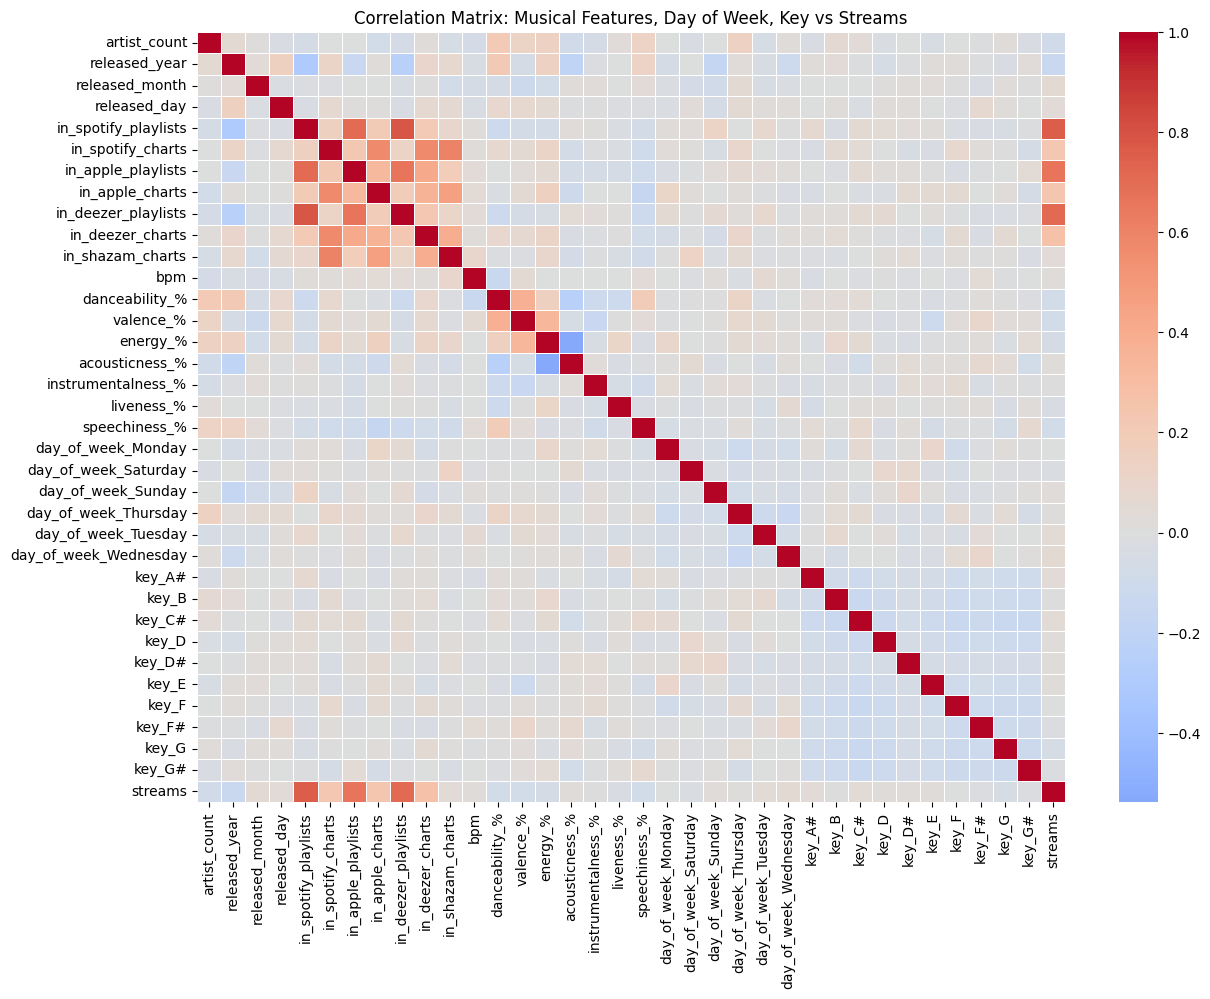

In [417]:
plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix: Musical Features, Day of Week, Key vs Streams")
plt.show()

In [418]:
corr_with_streams = corr_matrix['streams'].sort_values(ascending=False)
corr_with_streams

streams                  1.000000
in_spotify_playlists     0.759829
in_deezer_playlists      0.713119
in_apple_playlists       0.668079
in_deezer_charts         0.272716
in_apple_charts          0.241121
in_spotify_charts        0.231227
released_month           0.048771
day_of_week_Wednesday    0.047996
day_of_week_Tuesday      0.044463
key_C#                   0.043862
released_day             0.035451
in_shazam_charts         0.034057
key_A#                   0.033763
day_of_week_Sunday       0.030659
key_D                    0.020168
bpm                      0.018867
key_E                    0.018296
key_D#                   0.016422
acousticness_%           0.016240
day_of_week_Thursday     0.013203
key_B                    0.008148
instrumentalness_%       0.006287
key_F                    0.002402
day_of_week_Monday      -0.002918
key_G#                  -0.018020
key_F#                  -0.020176
day_of_week_Saturday    -0.021866
liveness_%              -0.035099
key_G         

In [419]:
corr_with_streams[X_cat.columns]

day_of_week_Monday      -0.002918
day_of_week_Saturday    -0.021866
day_of_week_Sunday       0.030659
day_of_week_Thursday     0.013203
day_of_week_Tuesday      0.044463
day_of_week_Wednesday    0.047996
key_A#                   0.033763
key_B                    0.008148
key_C#                   0.043862
key_D                    0.020168
key_D#                   0.016422
key_E                    0.018296
key_F                    0.002402
key_F#                  -0.020176
key_G                   -0.049342
key_G#                  -0.018020
Name: streams, dtype: float64